In [1]:
import openai as openai
import os
import json
from tqdm import tqdm
import time
import random
from pydantic import BaseModel
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

api_key = ''
with open('../../openai.txt', 'r') as file:
    api_key = file.read().replace('\n', '')

client = openai.OpenAI(api_key=api_key)

In [2]:
def list_models():
    """
    List all available models in the OpenAI API.
    """
    models = client.models.list()
    print("Available models:")

    model_ids = []
    for model in models.data:
        model_ids.append(model.id)

    model_ids.sort()
    for model_id in model_ids:
        print(model_id)

# list_models(client)

In [3]:
def costs(prompt_tokens, completion_tokens):
    """
    Calculate the costs based on the number of tokens used.
    Args:
        prompt_tokens (int): The number of prompt tokens used.
        completion_tokens (int): The number of completion tokens used.
    Returns:
        float: The total cost in dollars.
    """
    if model_used == 'gpt-4o-mini':
        price_per_1m_input_tokens = 0.15
        price_per_1m_output_tokens = 0.6
    elif model_used == 'gpt-4o':
        price_per_1m_input_tokens = 2.5
        price_per_1m_output_tokens = 10
    elif model_used == 'o4-mini':
        price_per_1m_input_tokens = 1.10
        price_per_1m_output_tokens = 4.40
    else:
        raise ValueError(
            "Model not set or not supported for cost calculation.")
    total_cost = ((prompt_tokens / 1000000) * price_per_1m_input_tokens) + \
        ((completion_tokens / 1000000) * price_per_1m_output_tokens)
    return total_cost

In [ ]:
class StructuredResponse(BaseModel):
    difference: int
    explanation: str


def llm_call(prompt):
    """
    Call the OpenAI API to get a response based on the provided system and user prompts.
    Args:
        prompt (str): The prompt to send to the OpenAI API.
    Returns:
        tuple: A tuple containing the answer, prompt tokens, completion tokens, and total tokens.
    """
    global global_prompt_tokens, global_completion_tokens

    retries = 0
    max_completion_tokens = 2000
    while True:
        try:
            response = client.beta.chat.completions.parse(
                model=model_used,
                messages=[
                    {"role": "system", "content": prompt}
                ],
                max_completion_tokens=max_completion_tokens,
                response_format=StructuredResponse
            )
            break
        except openai.LengthFinishReasonError as e:
            # Retry with larger max_completion_tokens
            max_completion_tokens *= 2

            prompt_tokens += e.completion.usage.prompt_tokens
            completion_tokens += e.completion.usage.completion_tokens
            total_tokens += e.completion.usage.total_tokens

            global_prompt_tokens += e.completion.usage.prompt_tokens
            global_completion_tokens += e.completion.usage.completion_tokens
        except Exception as e:
            retries += 1
            backoff_time = (2 ** retries) + random.random()
            print(f"Retrying in {backoff_time:.2f} seconds...")
            time.sleep(backoff_time)

    prompt_tokens = response.usage.prompt_tokens
    completion_tokens = response.usage.completion_tokens
    total_tokens = response.usage.total_tokens

    global_prompt_tokens += response.usage.prompt_tokens
    global_completion_tokens += response.usage.completion_tokens

    answer = response.choices[0].message.parsed.model_dump()

    # Uncomment the following lines to simulate a mock response
    # answer = {
    #     "difference": random.choice([-2, -1, 1, 2]),
    #     "explanation": "This is a mock response."
    # }
    # prompt_tokens = 100
    # completion_tokens = 200
    # total_tokens = prompt_tokens + completion_tokens

    # global_prompt_tokens += prompt_tokens
    # global_completion_tokens += completion_tokens

    return answer, prompt_tokens, completion_tokens, total_tokens

In [5]:
def comparison(first, f_number, f_student_level, f_materials, second, s_number, s_student_level, s_materials, topic, concepts, criteria, c_question):
    prompt = f"""
    You are an expert teacher in the field of reflection questions. Your task is to evaluate two responses containing a single reflective question based on given criteria. Not all key concepts need to be present in the question.
    
    The topic is {topic}.
    The key concepts are {concepts}
    The criteria is {criteria}: {c_question}
    
    Provide a difference score from list [-2, -1, 1, 2]. The more negative the score, the better is the first question over the second. The more positive the score, the better is the second question over the first. Then provide a brief explanation of the chosen difference (at most 2 sentences).

    Question 1: 
    {first}
    Question 2: 
    {second}
    """

    answer, pt, ct, tt = llm_call(prompt)

    return {
        "first": first,
        "first_attempt": f_number,
        'first_student_level': f_student_level,
        'first_materials': f_materials,
        "second": second,
        "second_attempt": s_number,
        'second_student_level': s_student_level,
        'second_materials': s_materials,
        'criteria': criteria,
        'difference': answer['difference'],
        'explanation': answer['explanation'],
        'prompt_tokens': pt,
        'completion_tokens': ct,
        'total_tokens': tt,
    }

In [6]:
def load_data(file, count):
    data = []
    with open(file, 'r') as f:
        loaded_data = json.load(f)

        combinations = [[True, True], [True, False],
                        [False, True], [False, False]]

        for i, comb in enumerate(combinations):
            student_level = comb[0]
            materials = comb[1]

            # Get up to 'count' items for each combination
            for item in loaded_data:
                if len(data) >= (i + 1) * count:
                    break
                if (item['metadata']['student_level'] == student_level and
                        item['metadata']['materials'] == materials):
                    data.append(item)
    return data

In [ ]:
def evaluate(file, count, topic, concepts):
    file_name = file.split('iter.json')[0]
    results = file_name + "comb.csv"

    for filename in os.listdir('.'):
        if filename.startswith(results):
            os.remove(filename)

    data = load_data(file, count)

    # The list of criteria
    criteria = {
        "clarity": "Is the question clearly stated and easy to understand?",
        "relevance": "Is the question relevant to the topic?",
        "depth": "Does the question encourage critical thinking and deeper exploration of the topic?",
        "overall_quality": "Is the question of high quality overall, well-structured and thought-provoking?",
    }

    combinations = [[True, True], [True, False],
                    [False, True], [False, False]]

    rows = []

    for i, comb in enumerate(combinations):
        for j, comb2 in enumerate(combinations):
            # Skip all the combinations that were already compared
            if i >= j:
                continue

            # Get all members of the first combination and the second combination
            first_subset = []
            for item in data:
                metadata = item['metadata']
                if metadata['student_level'] == comb[0] and \
                        metadata['materials'] == comb[1]:
                    first_subset.append(item)

            second_subset = []
            for item in data:
                metadata = item['metadata']
                if metadata['student_level'] == comb2[0] and \
                        metadata['materials'] == comb2[1]:
                    second_subset.append(item)

            # Compare each item in the first subset with each item in the second subset
            for item in tqdm(first_subset, desc=f"Comparing items in {comb} with {comb2}", total=len(first_subset)):
                for item2 in second_subset:
                    for message in reversed(item['student']):
                        if message['role'] == 'assistant':
                            f = message['content']
                            break
                    f_sl = item['metadata']['student_level']
                    f_m = item['metadata']['materials']
                    f_n = item['metadata']['attempt']

                    for message in reversed(item2['student']):
                        if message['role'] == 'assistant':
                            s = message['content']
                            break
                    s_sl = item2['metadata']['student_level']
                    s_m = item2['metadata']['materials']
                    s_n = item2['metadata']['attempt']

                    for c in criteria:
                        rows.append(comparison(
                            f, f_n, f_sl, f_m, s, s_n, s_sl, s_m, topic, concepts, c, criteria[c]))

            df = pd.DataFrame(rows)
            df.to_csv(results, index=False)


def evaluation(files, count, topic, concepts):
    # Call the evaluate function for each file
    for i in range(len(files)):
        print(f"Evaluating combinations of {files[i]}")
        evaluate(files[i], count, topic, concepts)

In [ ]:
model_used = "o4-mini"

global_prompt_tokens = 0
global_completion_tokens = 0

# Experiment settings
files = ['free10iter.json', 'fixed5iter.json', 'fixed10iter.json'] # List of files to evaluate (there can be only one)
topic = "Basics of how the internet works"
concepts = """
 - Decentralization of the internet
 - Servers, datacenters and routers
 - Server vs client
 - Data packets
 - IP addresses
"""
count = 5  # How many members of each combination from each file to use

evaluation(files, count, topic, concepts)

Evaluating combinations of free10iter.json


Comparing items in [True, True] with [True, False]: 100%|██████████| 5/5 [07:39<00:00, 91.80s/it]
Comparing items in [True, True] with [False, True]: 100%|██████████| 5/5 [07:23<00:00, 88.61s/it]
Comparing items in [True, True] with [False, False]: 100%|██████████| 5/5 [09:30<00:00, 114.03s/it]
Comparing items in [True, False] with [False, True]: 100%|██████████| 5/5 [07:22<00:00, 88.50s/it]
Comparing items in [True, False] with [False, False]: 100%|██████████| 5/5 [08:13<00:00, 98.74s/it] 
Comparing items in [False, True] with [False, False]: 100%|██████████| 5/5 [07:20<00:00, 88.04s/it]


Evaluating combinations of fixed5iter.json


Comparing items in [True, True] with [True, False]: 100%|██████████| 5/5 [08:42<00:00, 104.56s/it]
Comparing items in [True, True] with [False, True]: 100%|██████████| 5/5 [07:27<00:00, 89.57s/it]
Comparing items in [True, True] with [False, False]: 100%|██████████| 5/5 [08:12<00:00, 98.45s/it]
Comparing items in [True, False] with [False, True]: 100%|██████████| 5/5 [07:28<00:00, 89.64s/it]
Comparing items in [True, False] with [False, False]: 100%|██████████| 5/5 [09:16<00:00, 111.26s/it]
Comparing items in [False, True] with [False, False]: 100%|██████████| 5/5 [07:59<00:00, 95.81s/it] 


Evaluating combinations of fixed10iter.json


Comparing items in [True, True] with [True, False]: 100%|██████████| 5/5 [07:05<00:00, 85.13s/it]
Comparing items in [True, True] with [False, True]: 100%|██████████| 5/5 [08:31<00:00, 102.36s/it]
Comparing items in [True, True] with [False, False]: 100%|██████████| 5/5 [07:55<00:00, 95.04s/it] 
Comparing items in [True, False] with [False, True]: 100%|██████████| 5/5 [07:28<00:00, 89.73s/it] 
Comparing items in [True, False] with [False, False]: 100%|██████████| 5/5 [09:22<00:00, 112.58s/it]
Comparing items in [False, True] with [False, False]: 100%|██████████| 5/5 [07:24<00:00, 88.83s/it]


In [9]:
print("Total prompt tokens:", global_prompt_tokens)
print("Total completion tokens:", global_completion_tokens)
print(costs(global_prompt_tokens, global_completion_tokens))

Total prompt tokens: 1060230
Total completion tokens: 787453
4.6310462


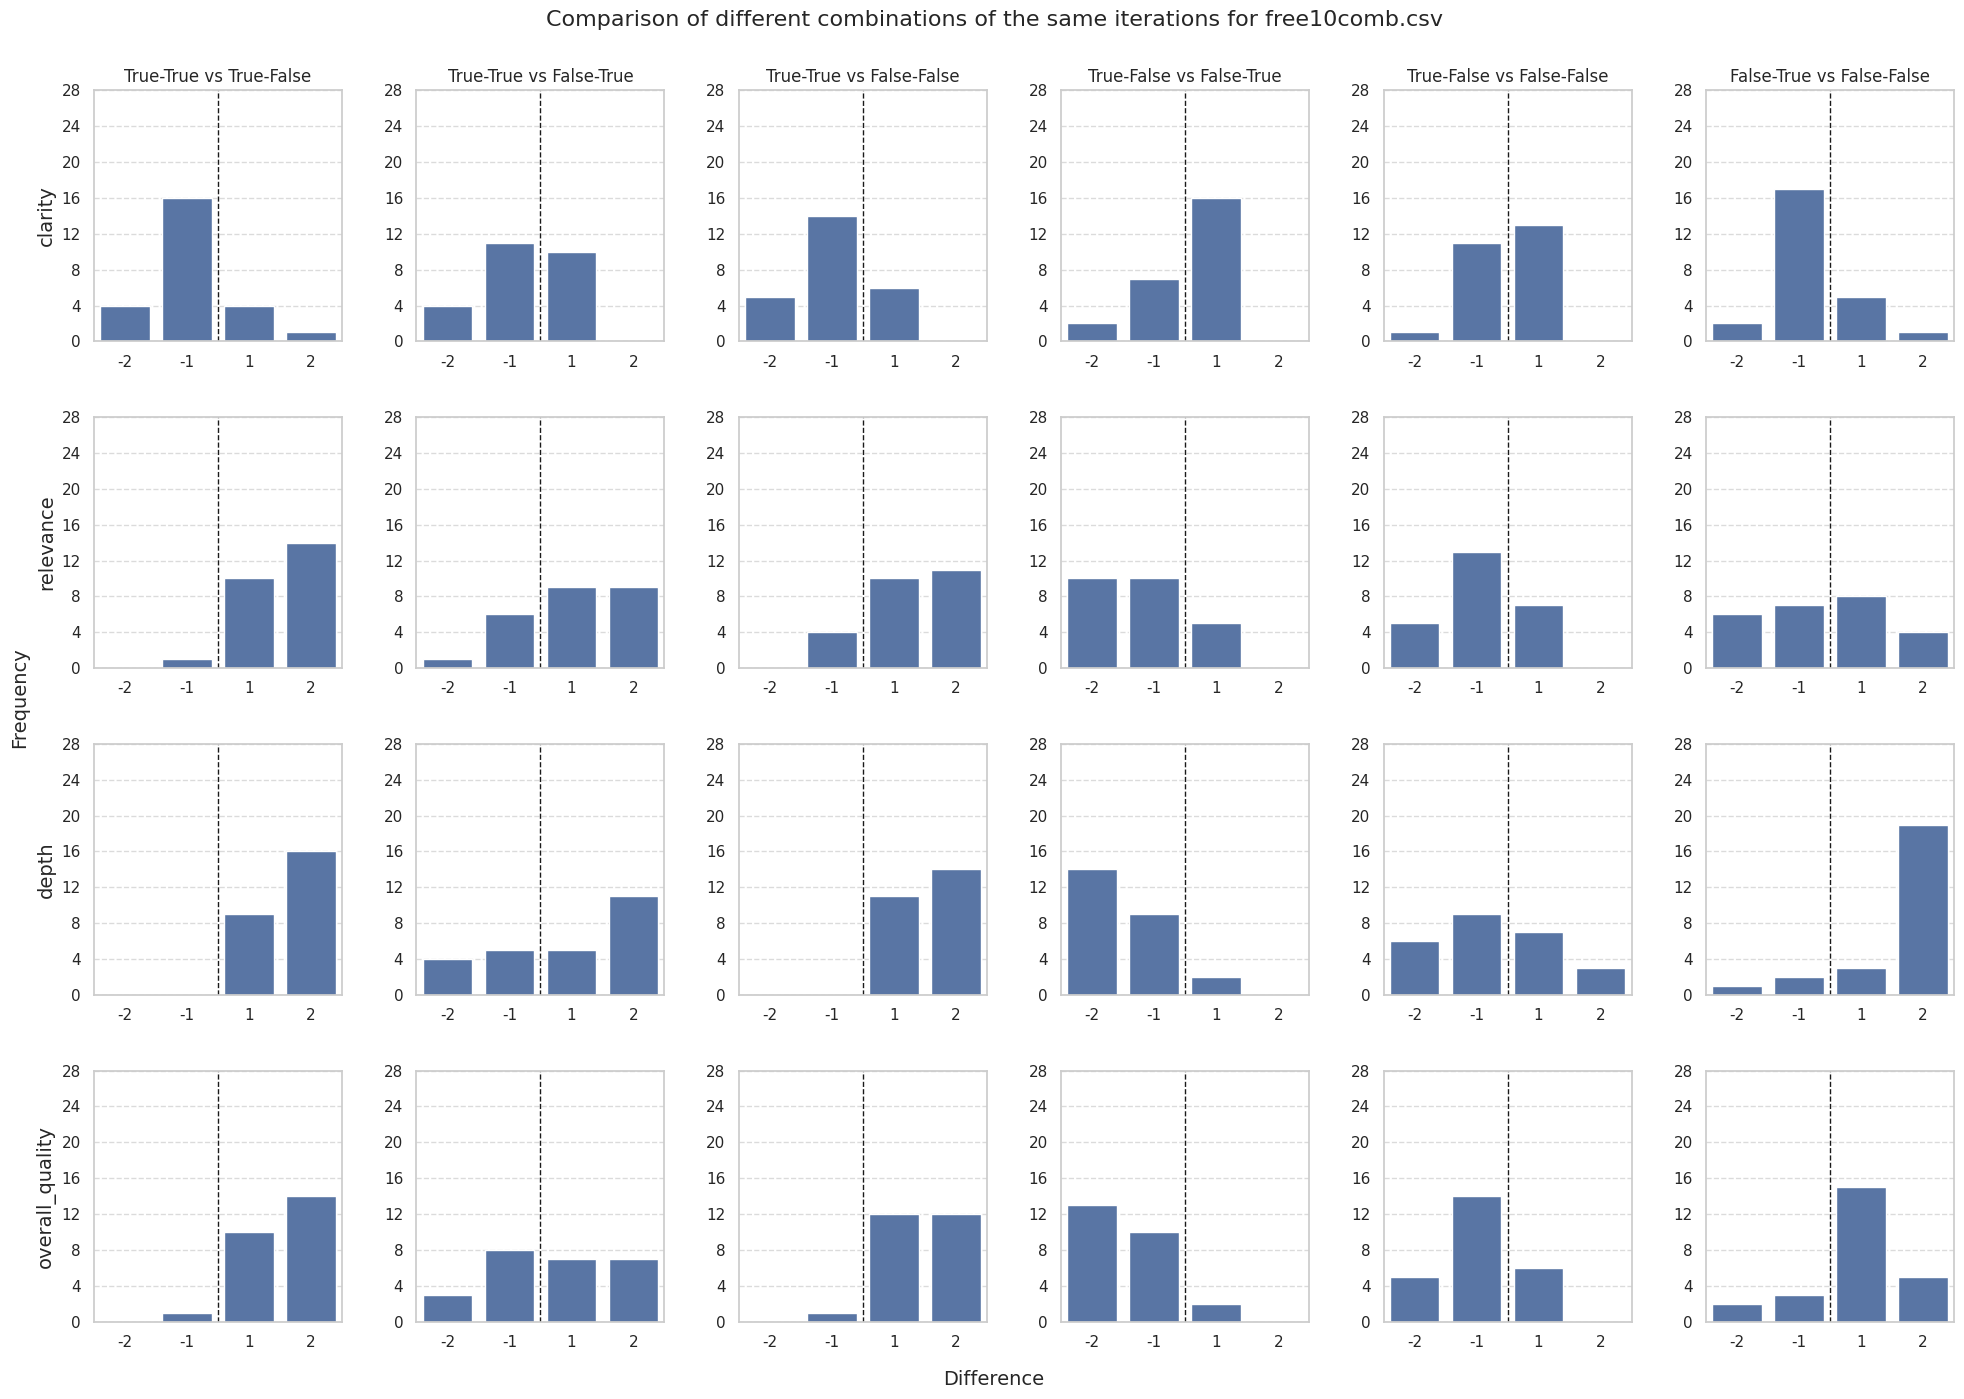

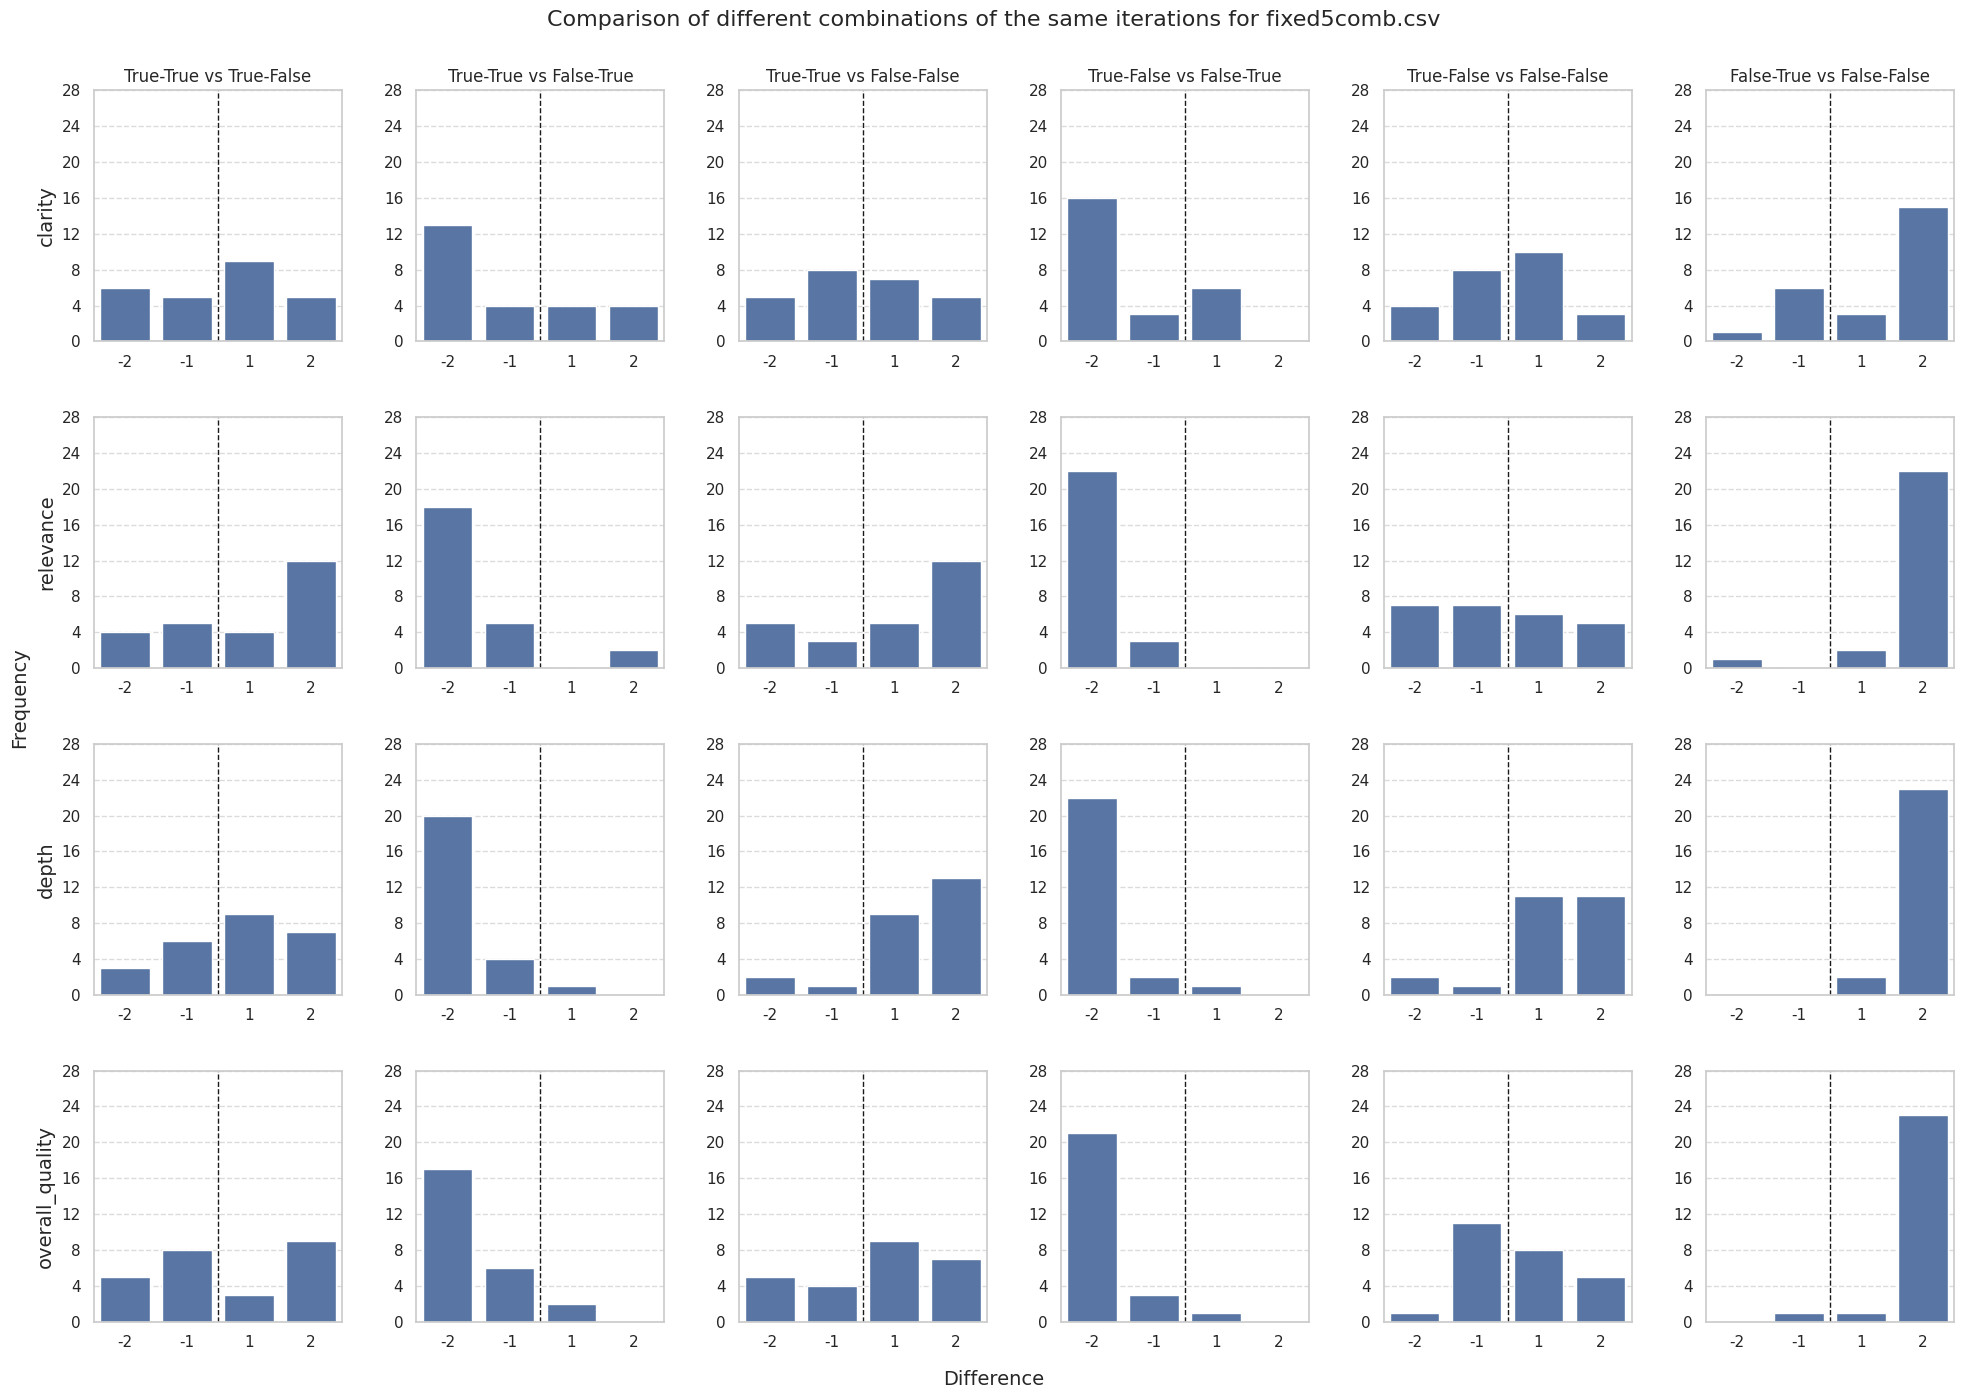

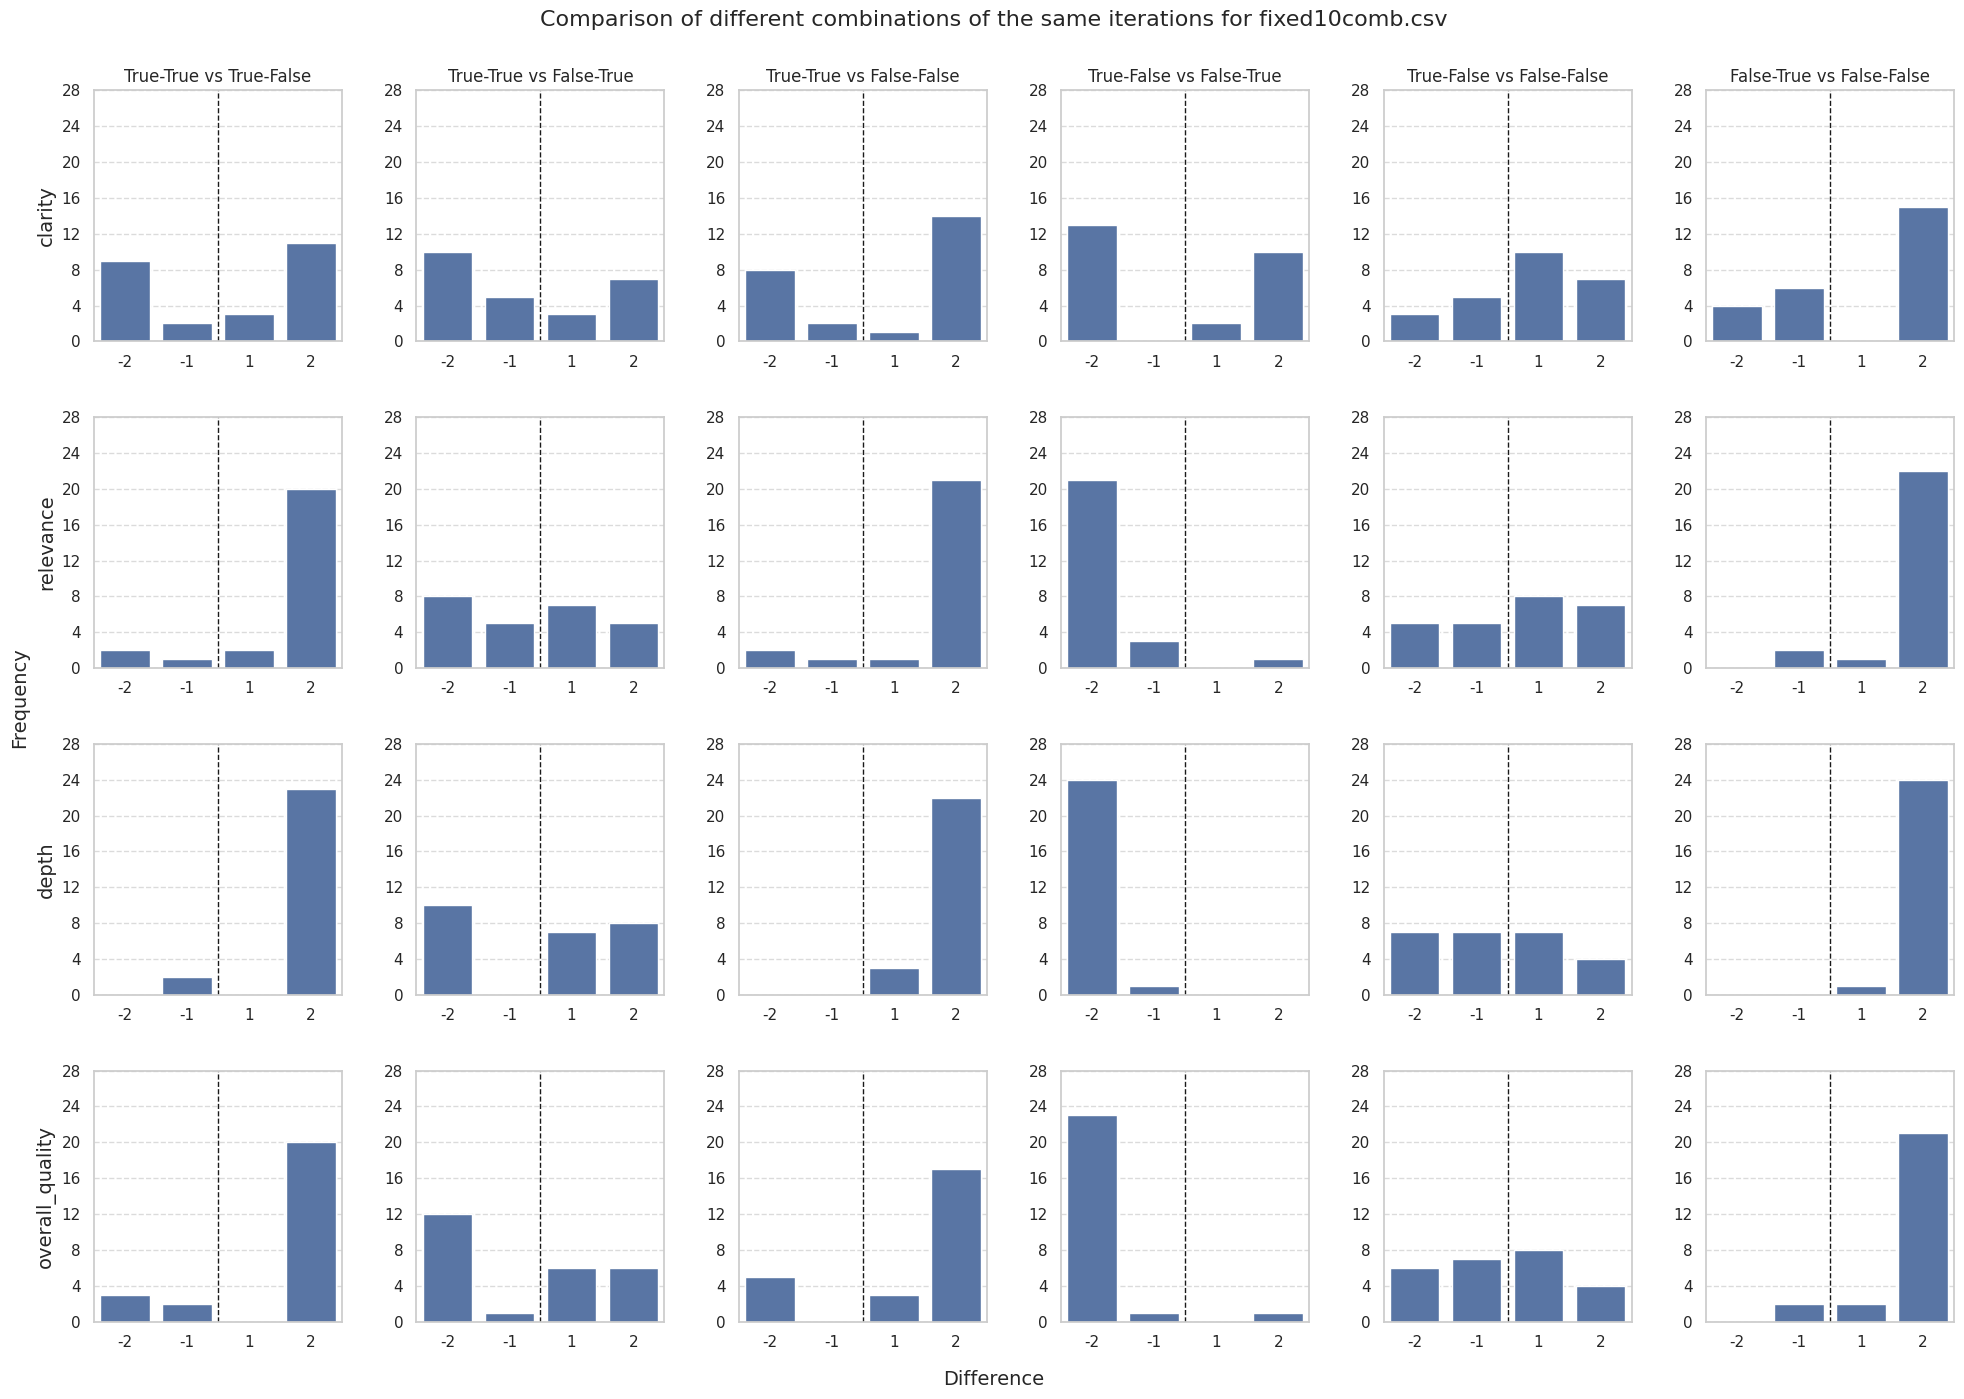

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def draw_arrow(ax, start_x, end_x, y, text):
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin

    dynamic_head_width = yrange * 0.03

    text_x_no_dialogue = (start_x + end_x) / 2

    ax.arrow(start_x, y, (end_x - start_x), 0,
             head_width=dynamic_head_width,
             head_length=0.2,
             fc='black', ec='black', lw=1.5,
             length_includes_head=True)

    ax.text(text_x_no_dialogue,
            y + 0.015 * yrange, text, ha='center', va='bottom')


sns.set_theme(style="whitegrid")

files = ['free10comb.csv', 'fixed5comb.csv', 'fixed10comb.csv']

for f in files:
    with open(f, 'r') as file:
        data = pd.read_csv(file)

    fig, axs = plt.subplots(4, 6, figsize=(24, 16))

    for i, c in enumerate(data['criteria'].unique()):
        fig.suptitle(
            f"Comparison of different combinations of the same iterations for {f}", fontsize=16, y=0.93)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        if i == 0:
            fig.text(0.5, fig.subplotpars.bottom - 0.03,
                     "Difference", ha='center', va='top', fontsize=14)
            fig.text(0.09, 0.5, "Frequency", va='center',
                     rotation='vertical', fontsize=14)

        combinations = [[True, True], [True, False],
                        [False, True], [False, False]]

        idx = 0
        for j, comb in enumerate(combinations):
            for k, comb2 in enumerate(combinations):
                if j >= k:
                    continue

                # Filter the data for the current criteria
                subset = data[data['criteria'] == c]

                # Filter the data for the current combination
                subset = subset[subset['first_student_level'] == comb[0]]
                subset = subset[subset['first_materials'] == comb[1]]
                subset = subset[subset['second_student_level'] == comb2[0]]
                subset = subset[subset['second_materials'] == comb2[1]]

                difference = subset['difference'].value_counts()

                # Row for each criteria
                # Column for each combination
                ax = axs[i, idx]

                sns.barplot(
                    x=difference.index,
                    y=difference.values,
                    ax=ax,
                    order=[-2, -1, 1, 2],
                )

                ax.set_xlabel('')
                ax.set_ylabel('')

                # To only the first row add the title
                if i == 0:
                    ax.set_title(
                        f"{comb[0]}-{comb[1]} vs {comb2[0]}-{comb2[1]}", fontsize=12)

                # To the first column add the criteria
                if idx == 0:
                    ax.set_ylabel(c, fontsize=14)

                # Ensure correct labels to values
                ax.set_xlim(-0.5, 3.5)
                ax.set_xticks([0, 1, 2, 3])
                ax.set_xticklabels(['-2', '-1', '1', '2'])

                ax.set_yticks(range(0, 29, 4))
                ax.set_ylim(0, 28)

                ax.axvline(x=1.5, color='k', linestyle='--', linewidth=1)
                ax.grid(axis='y', linestyle='--', alpha=0.7)

                idx += 1

    # plt.savefig(f'Images/{f.split(".")[0]}_all.png', dpi=300, bbox_inches='tight')
    plt.show()

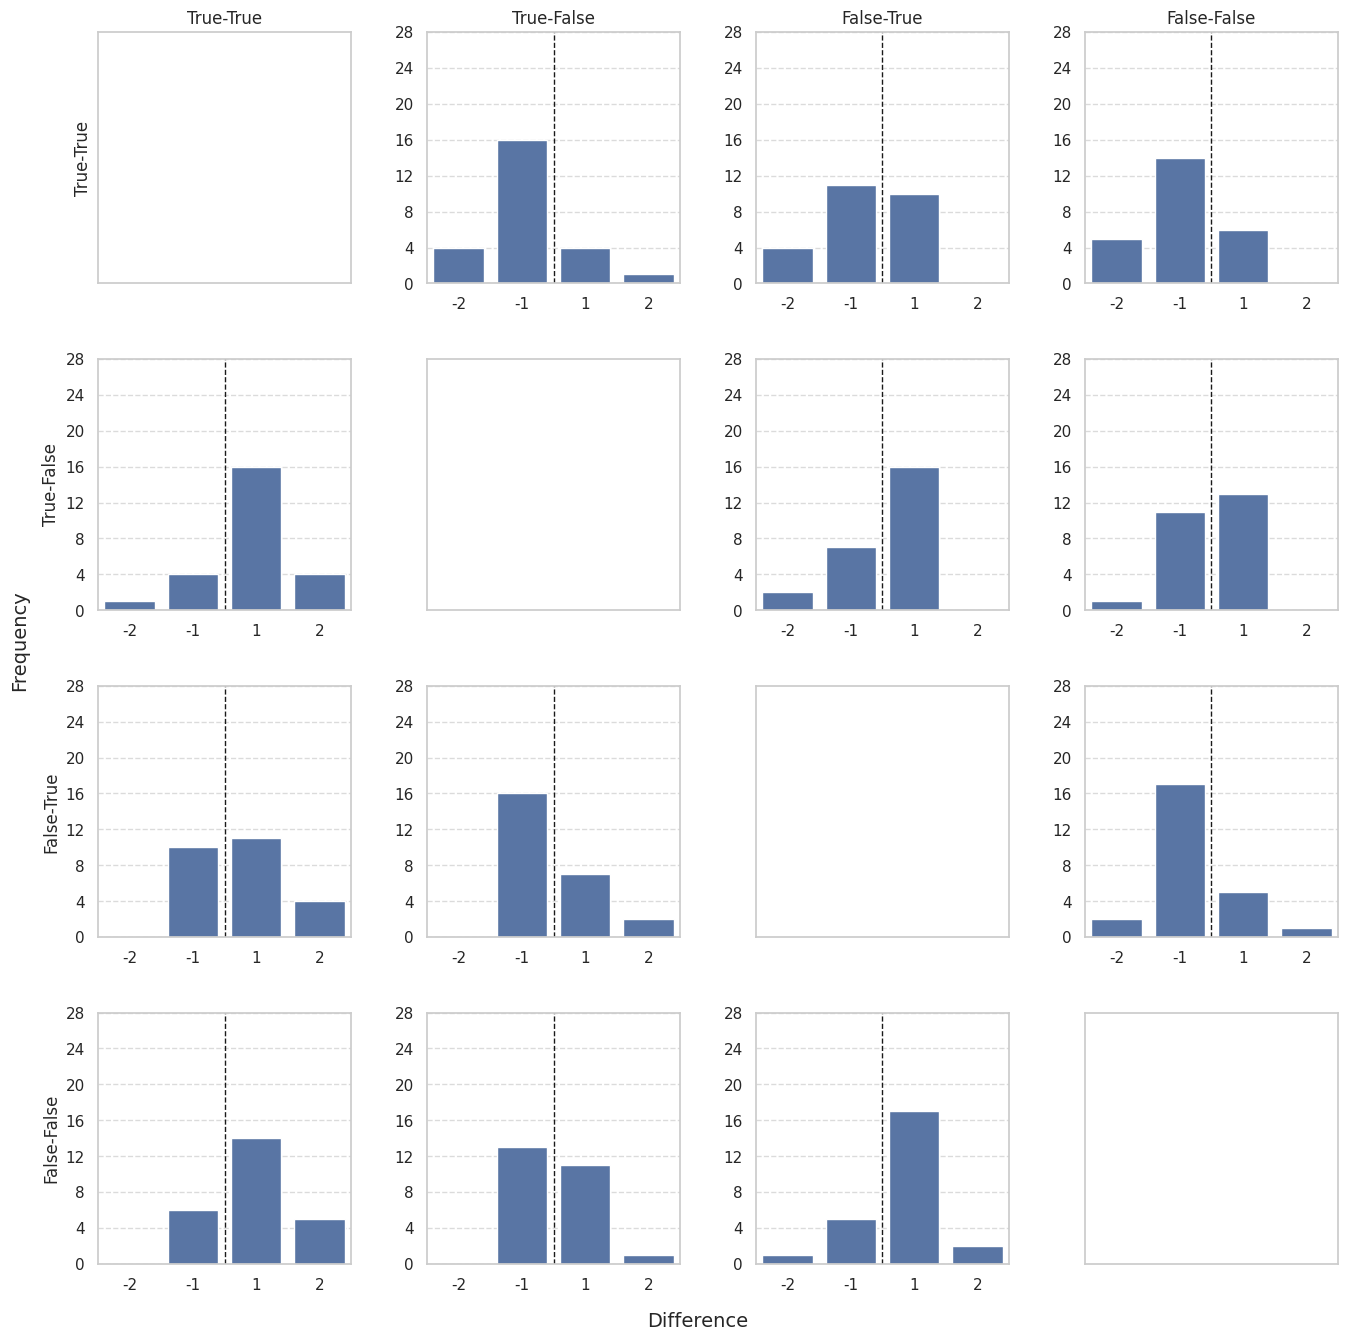

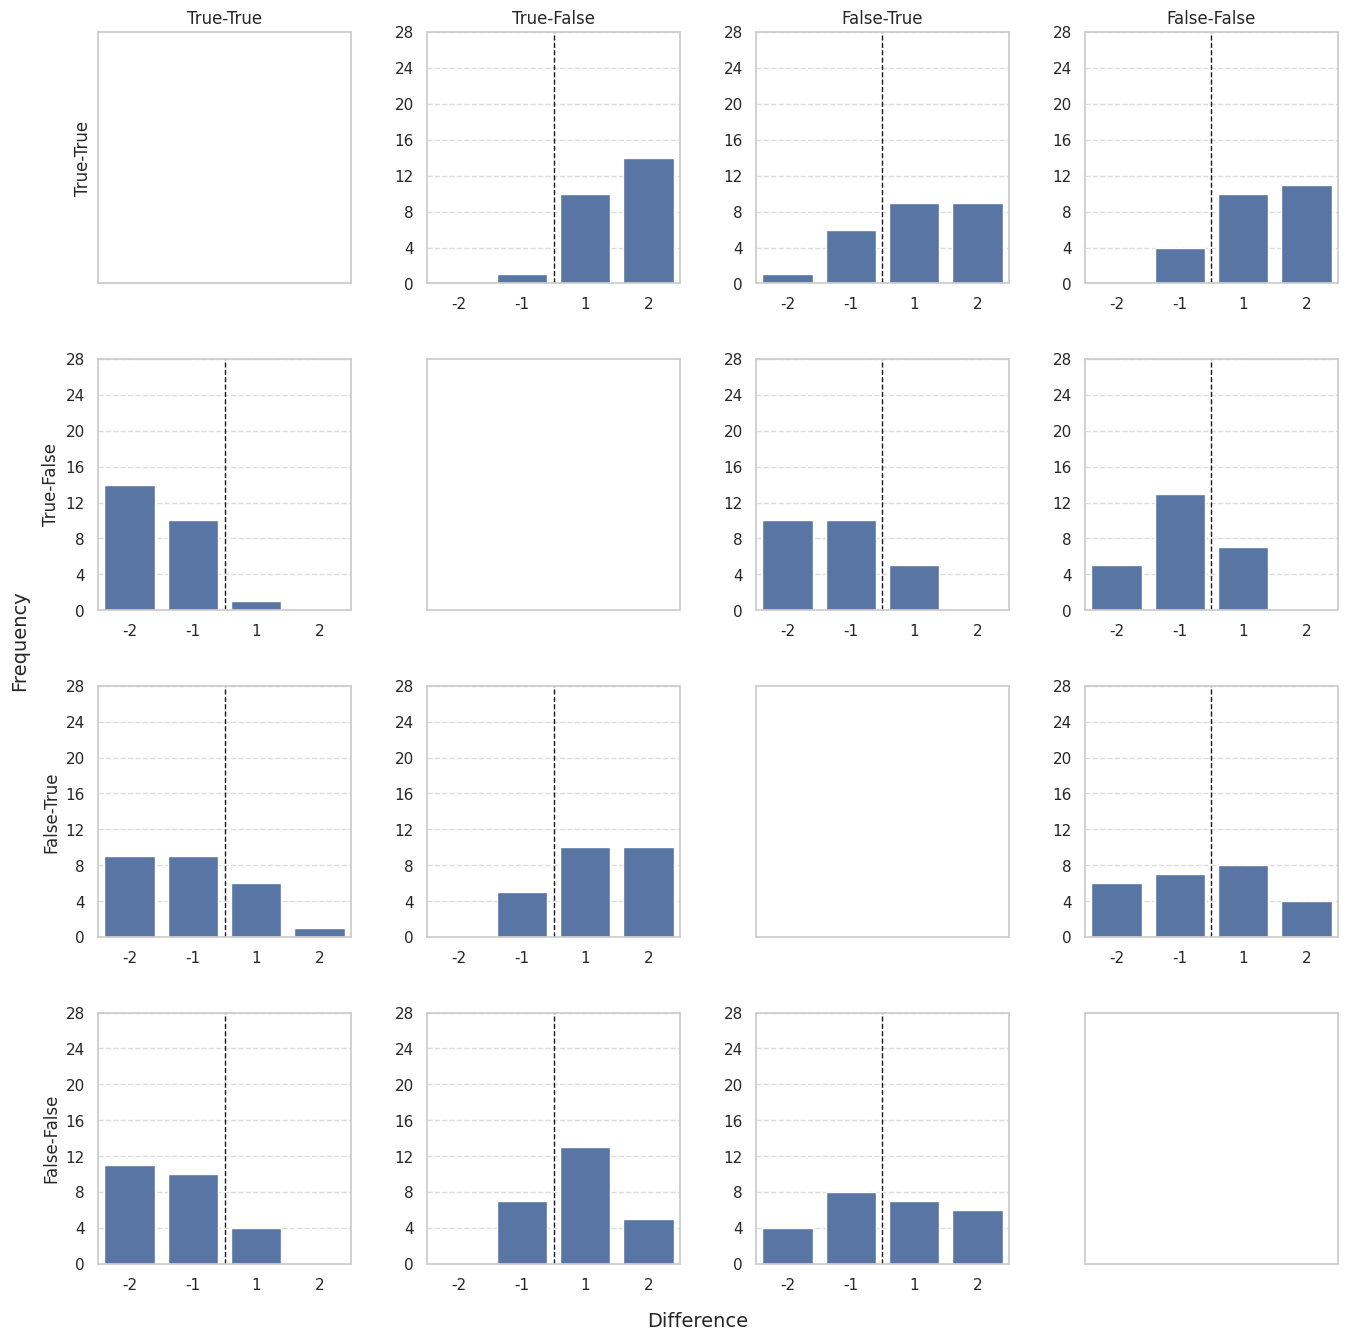

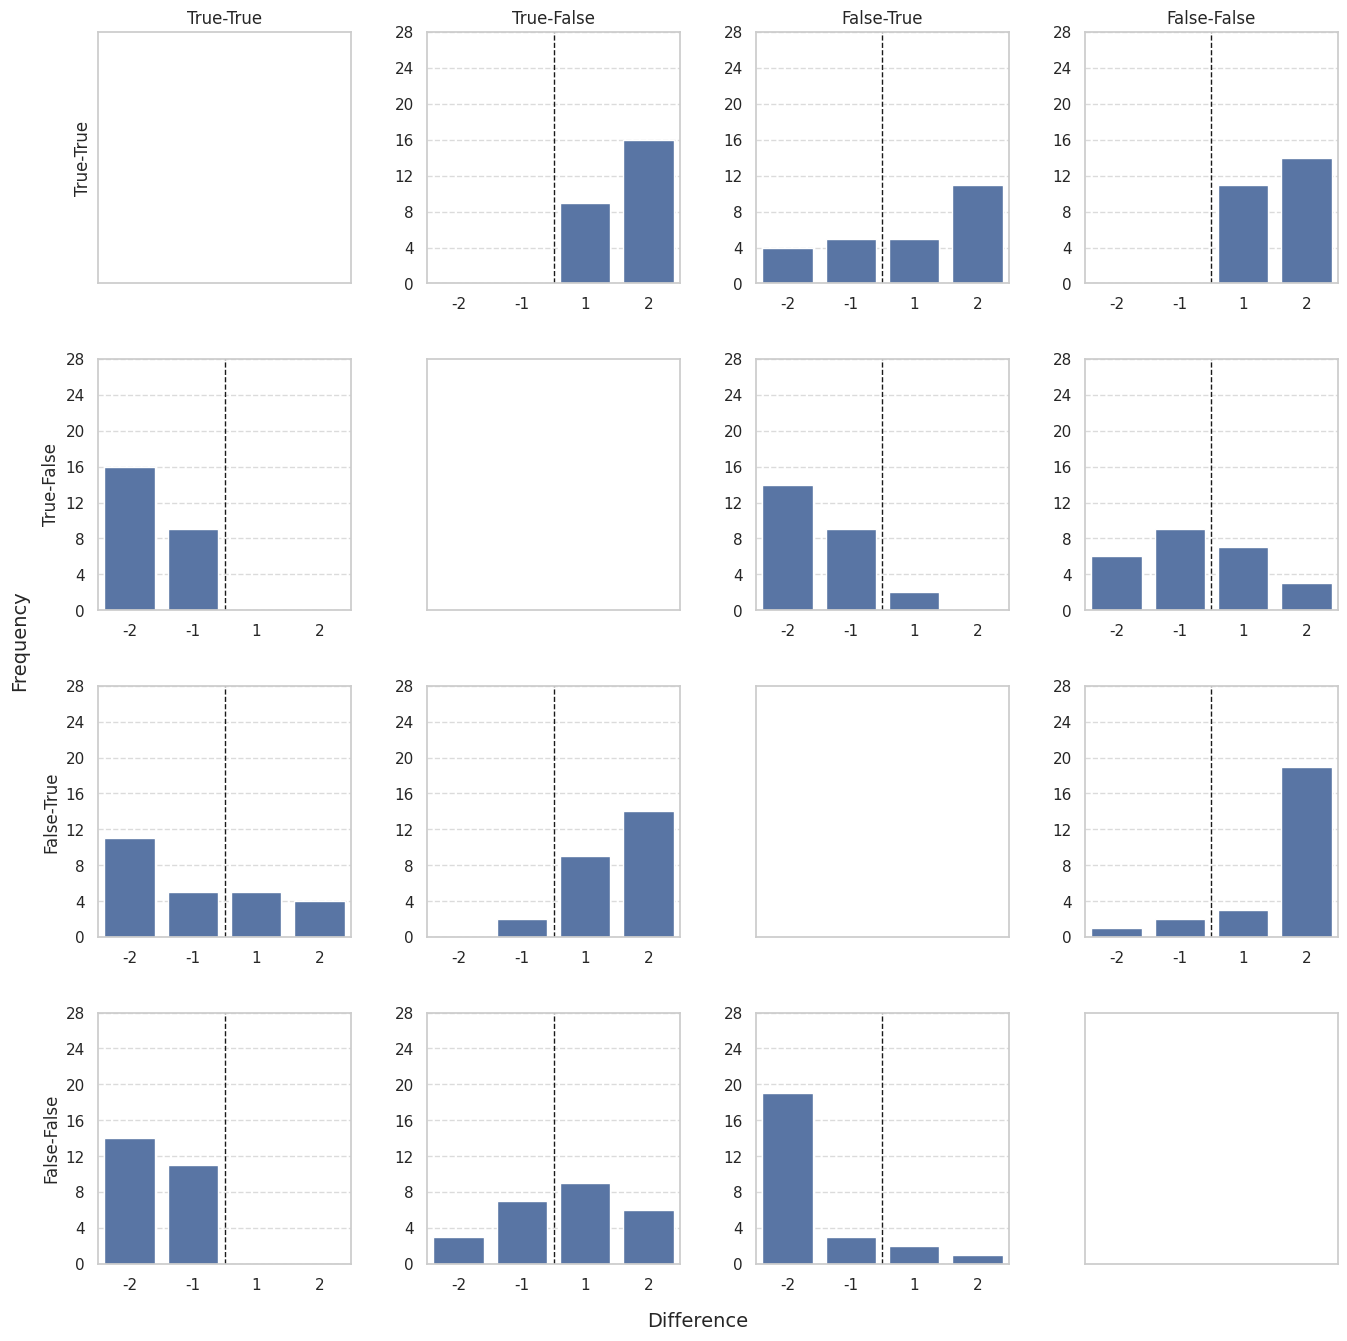

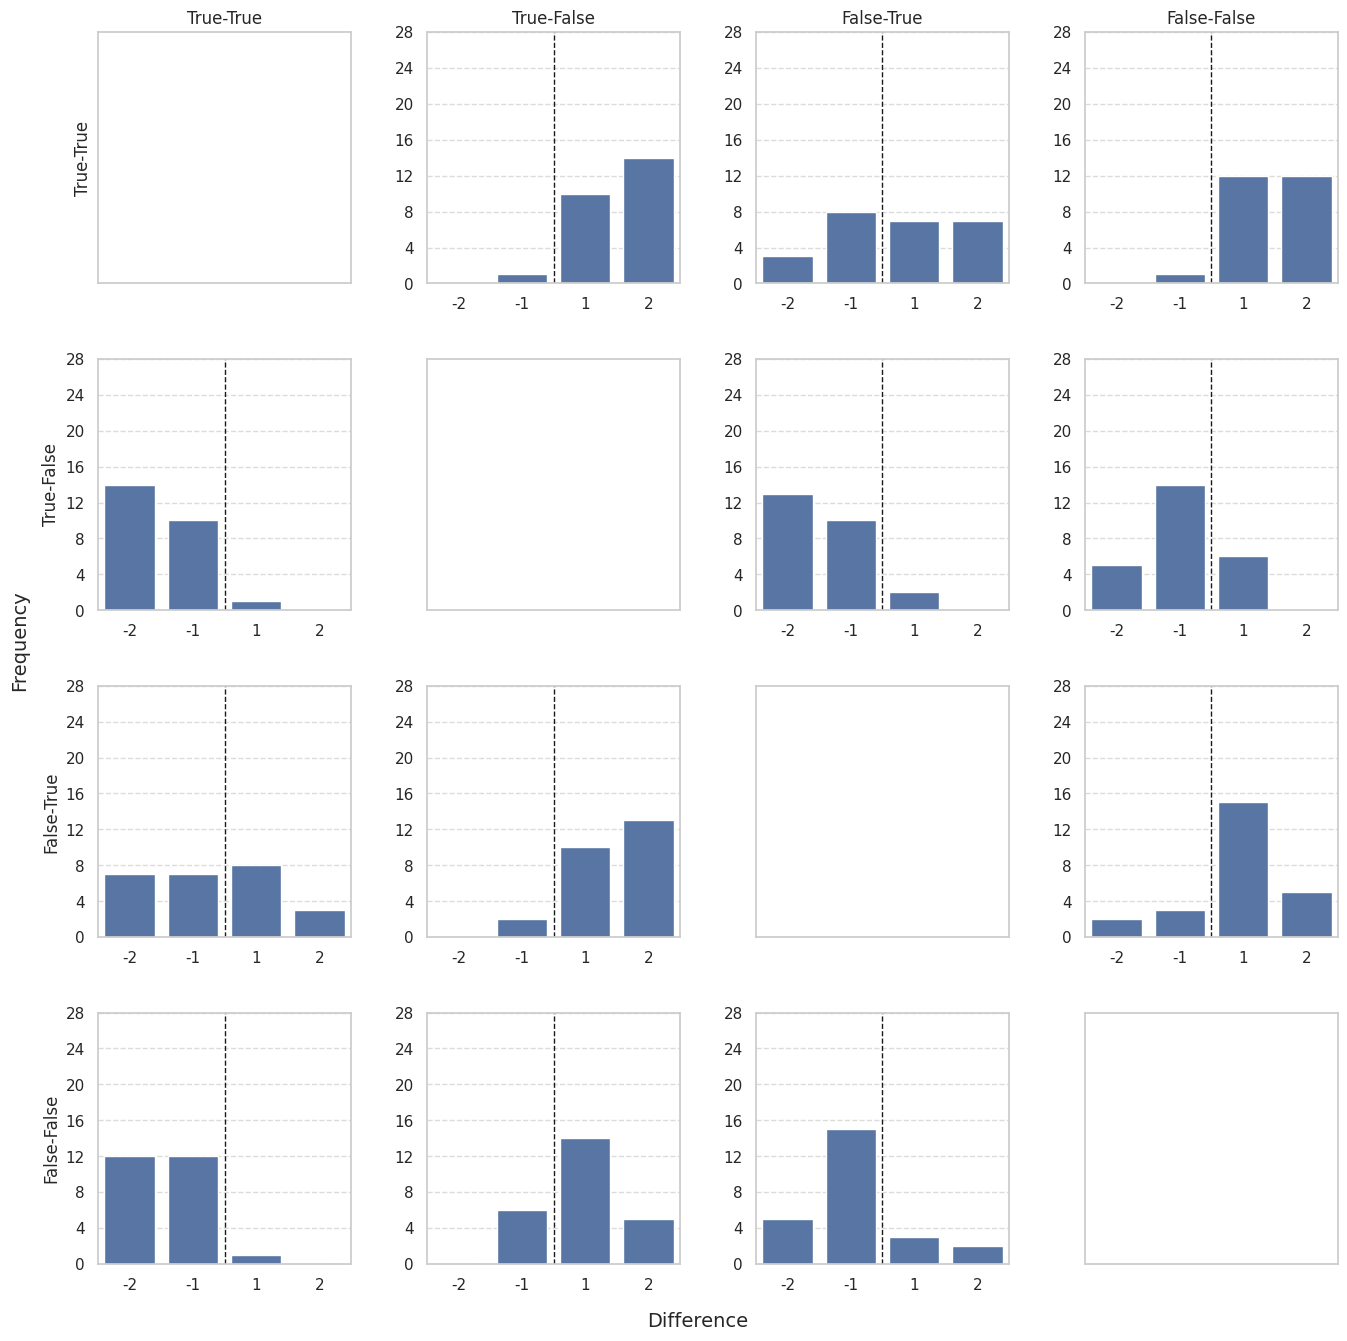

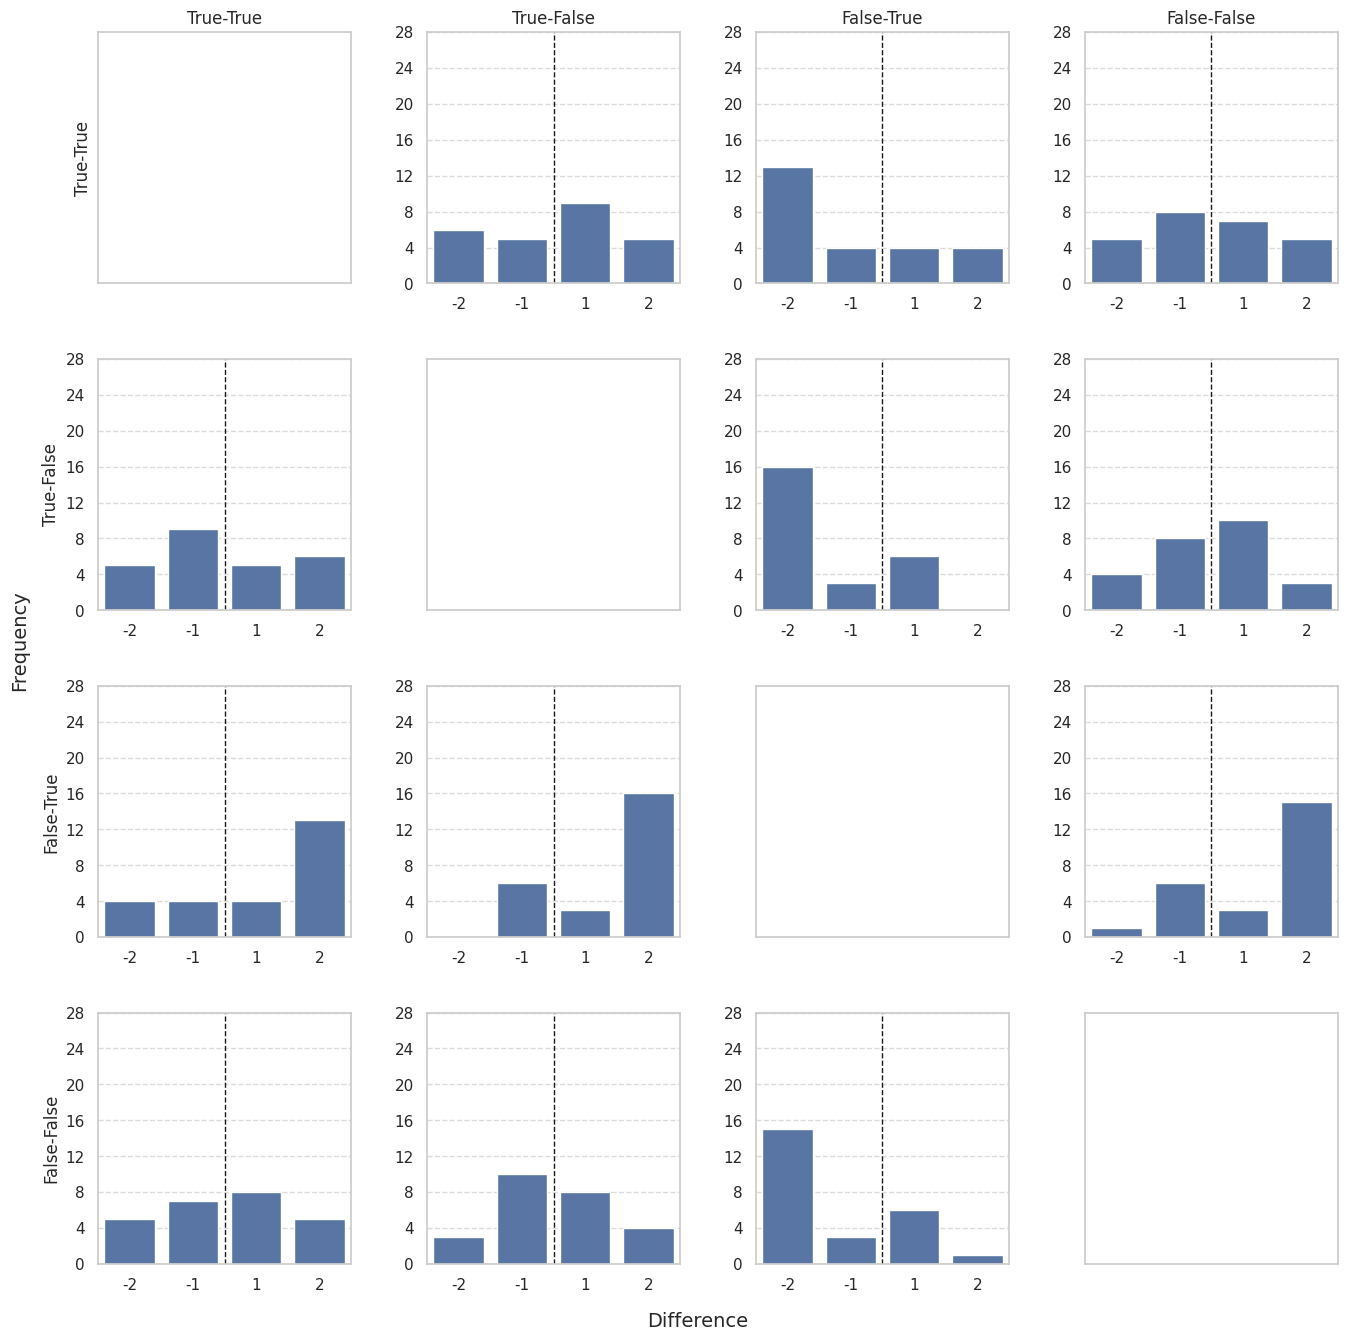

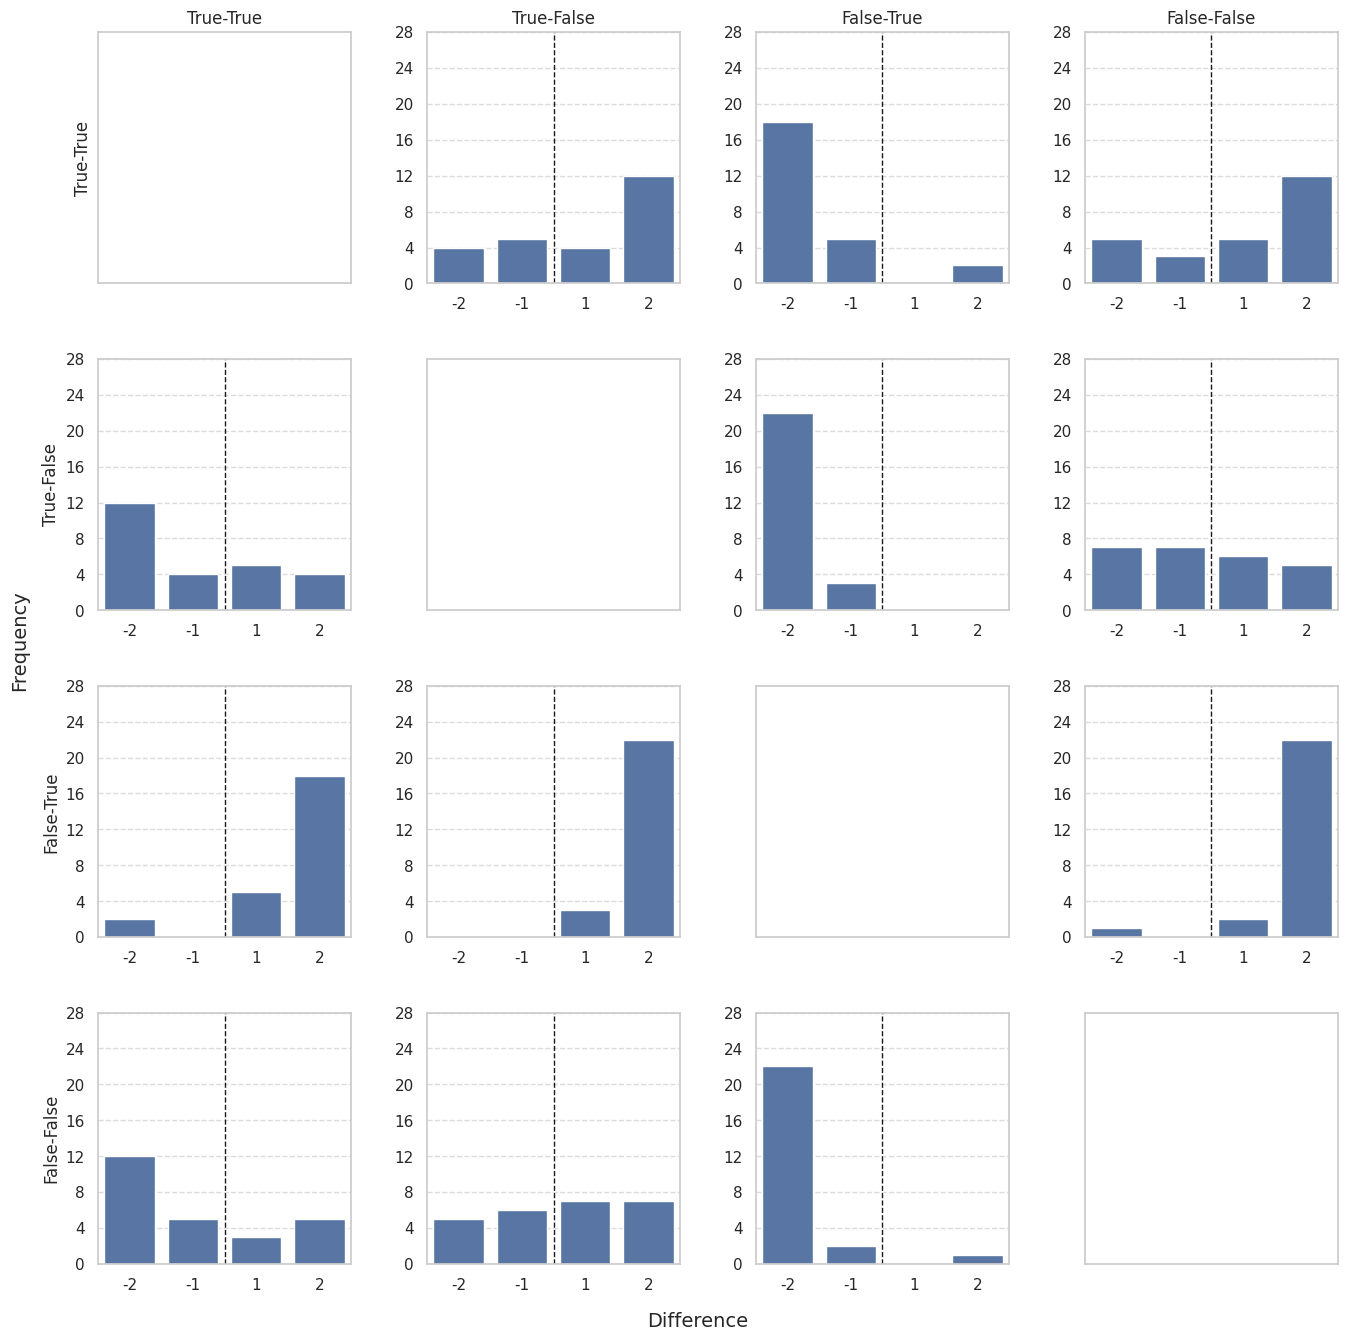

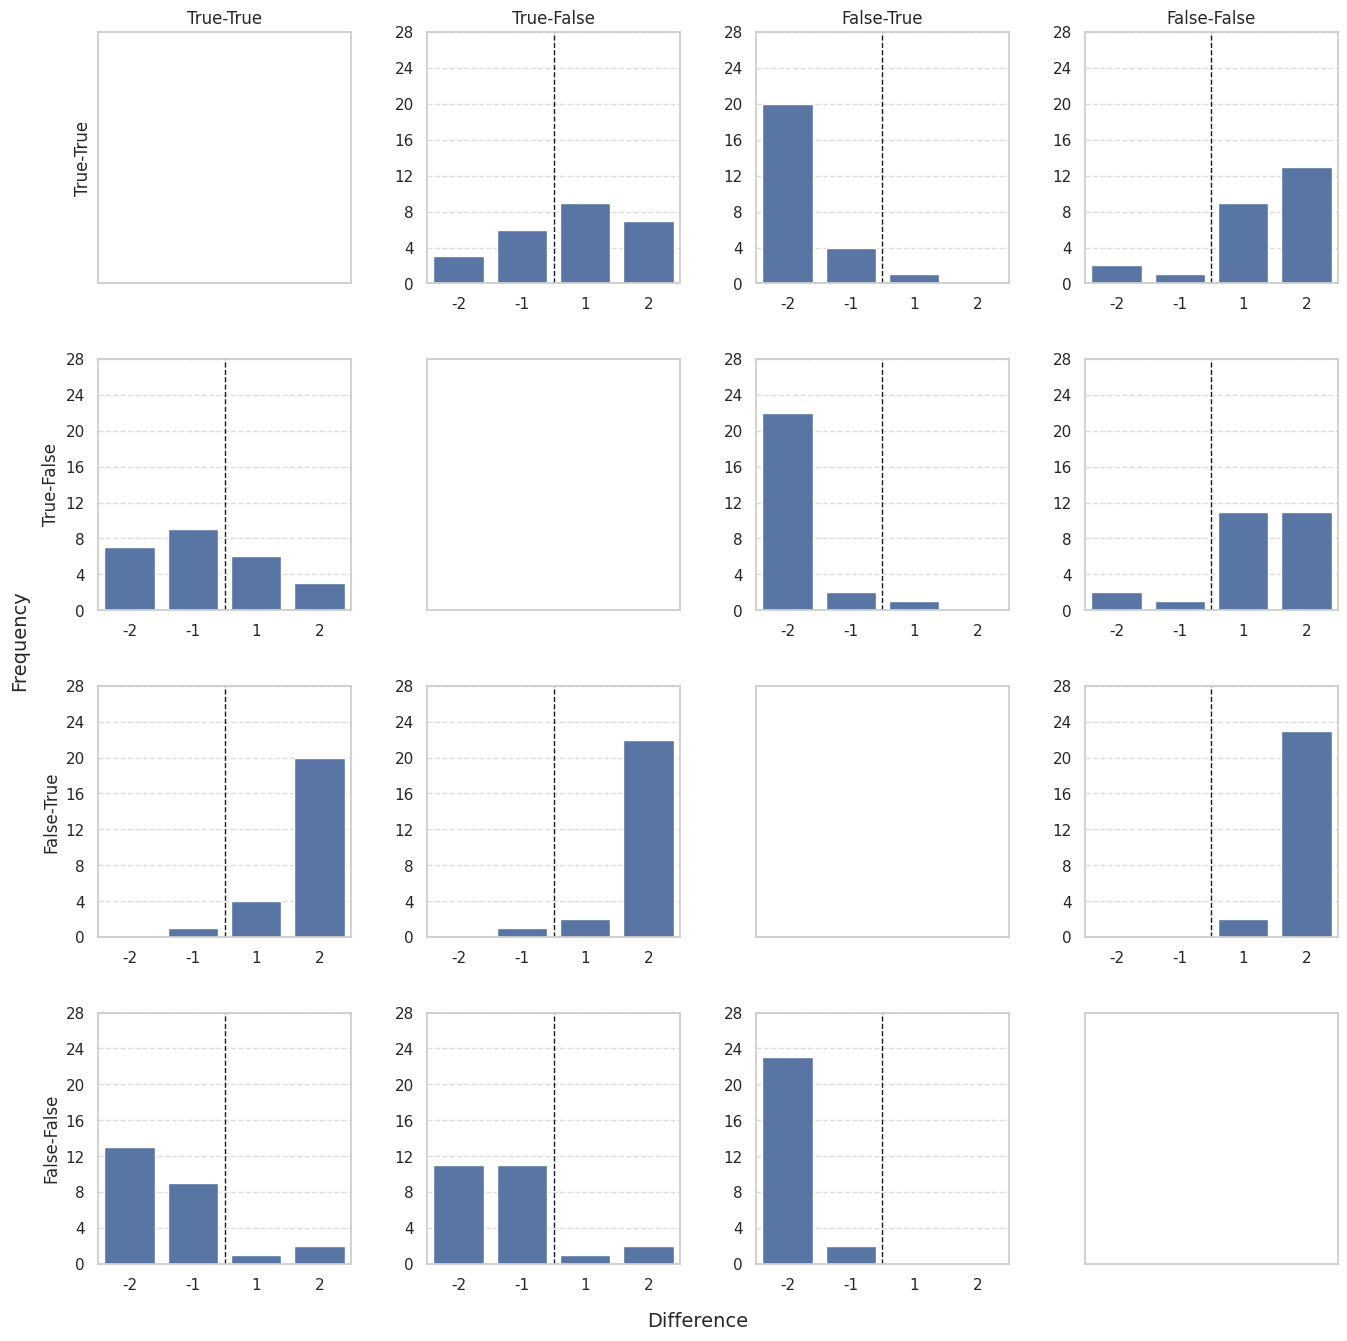

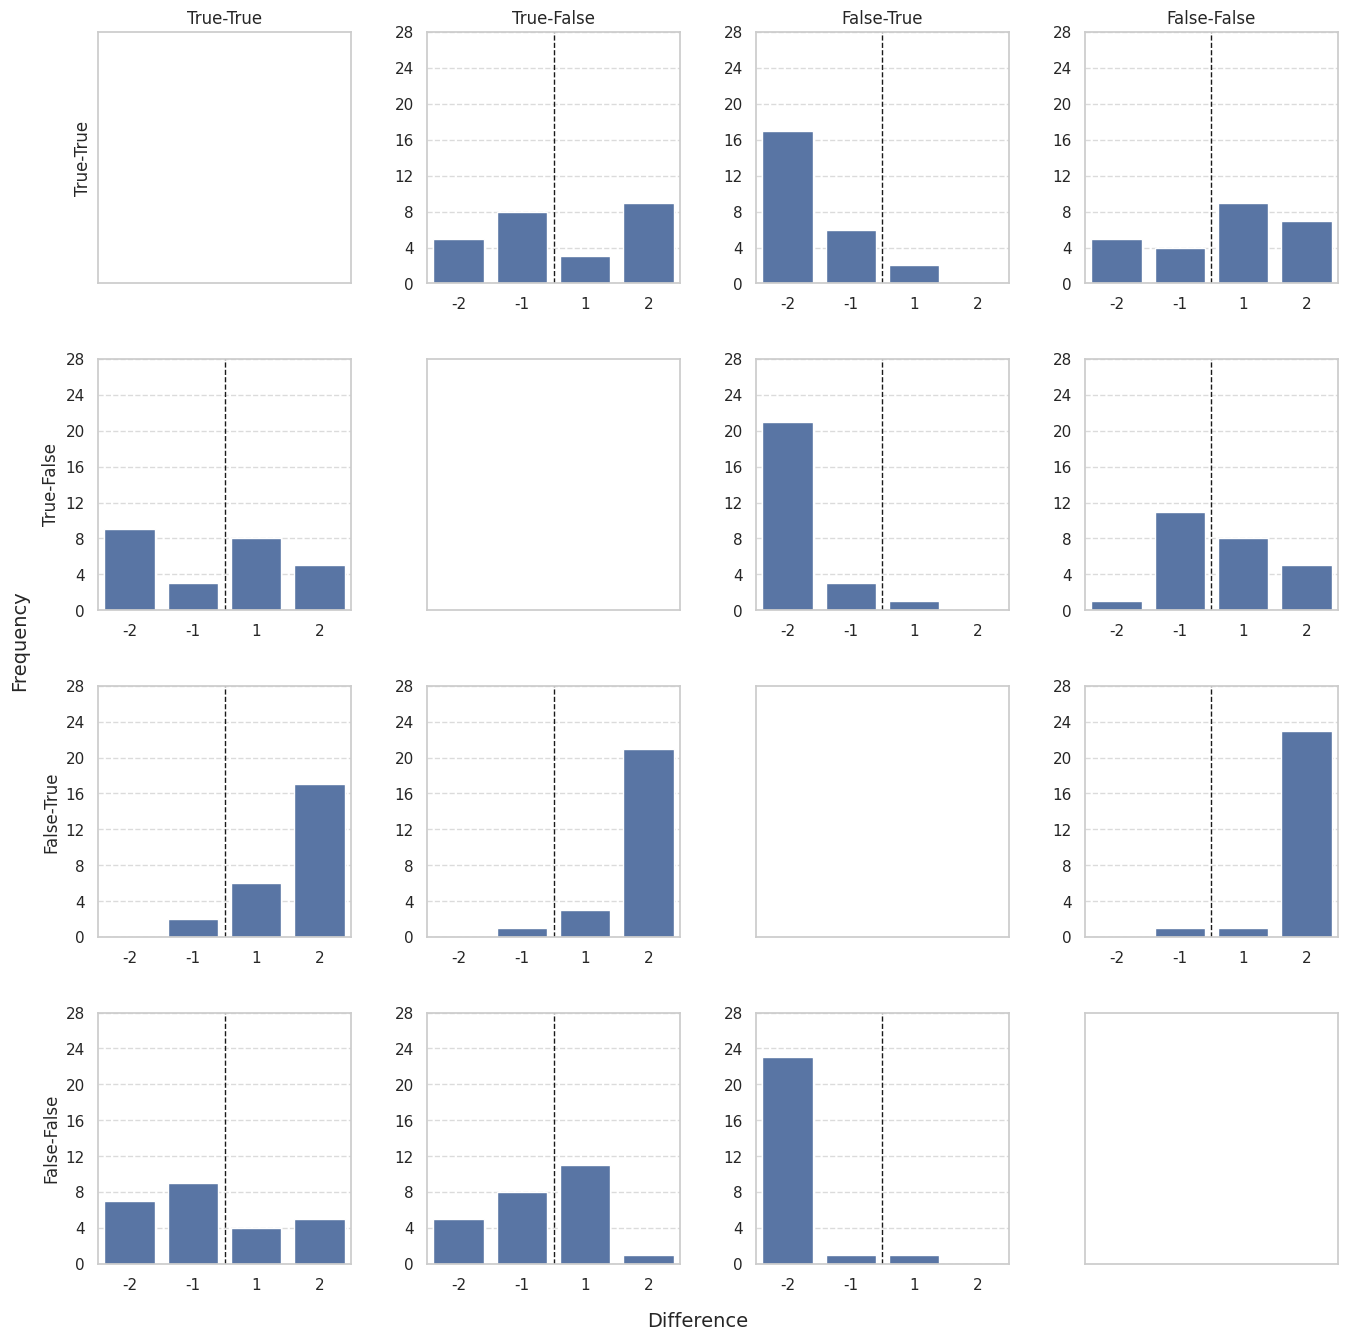

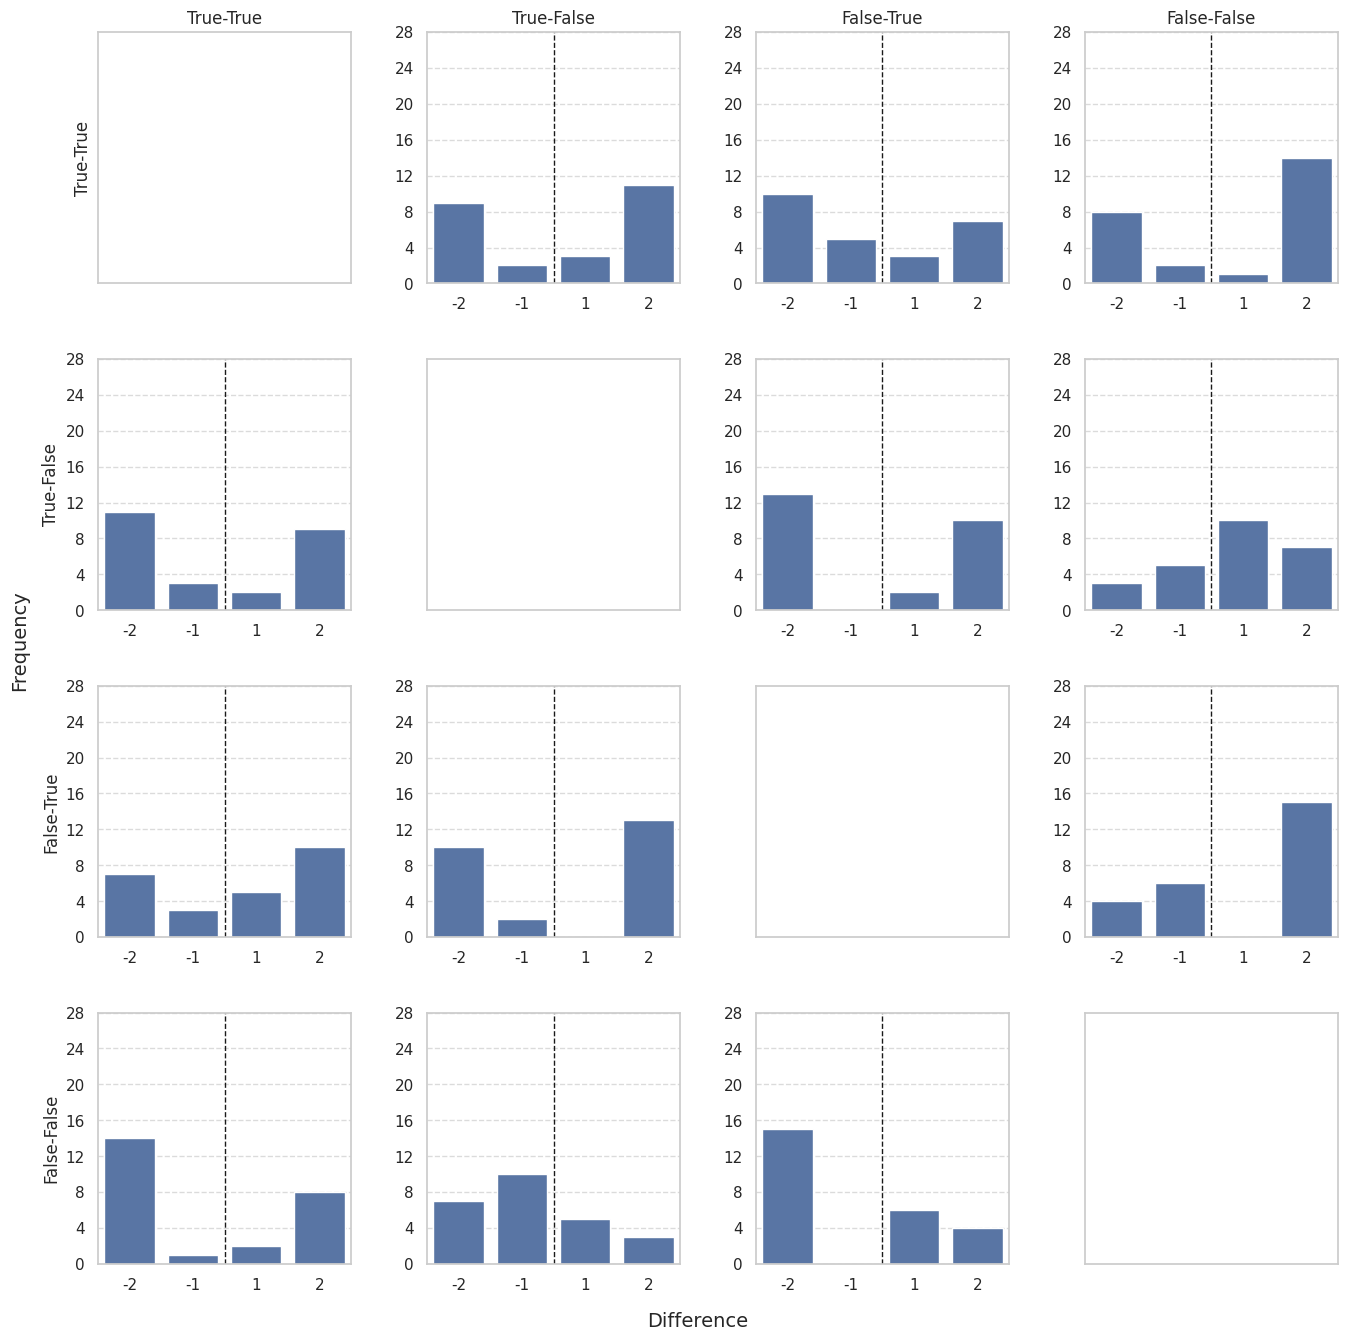

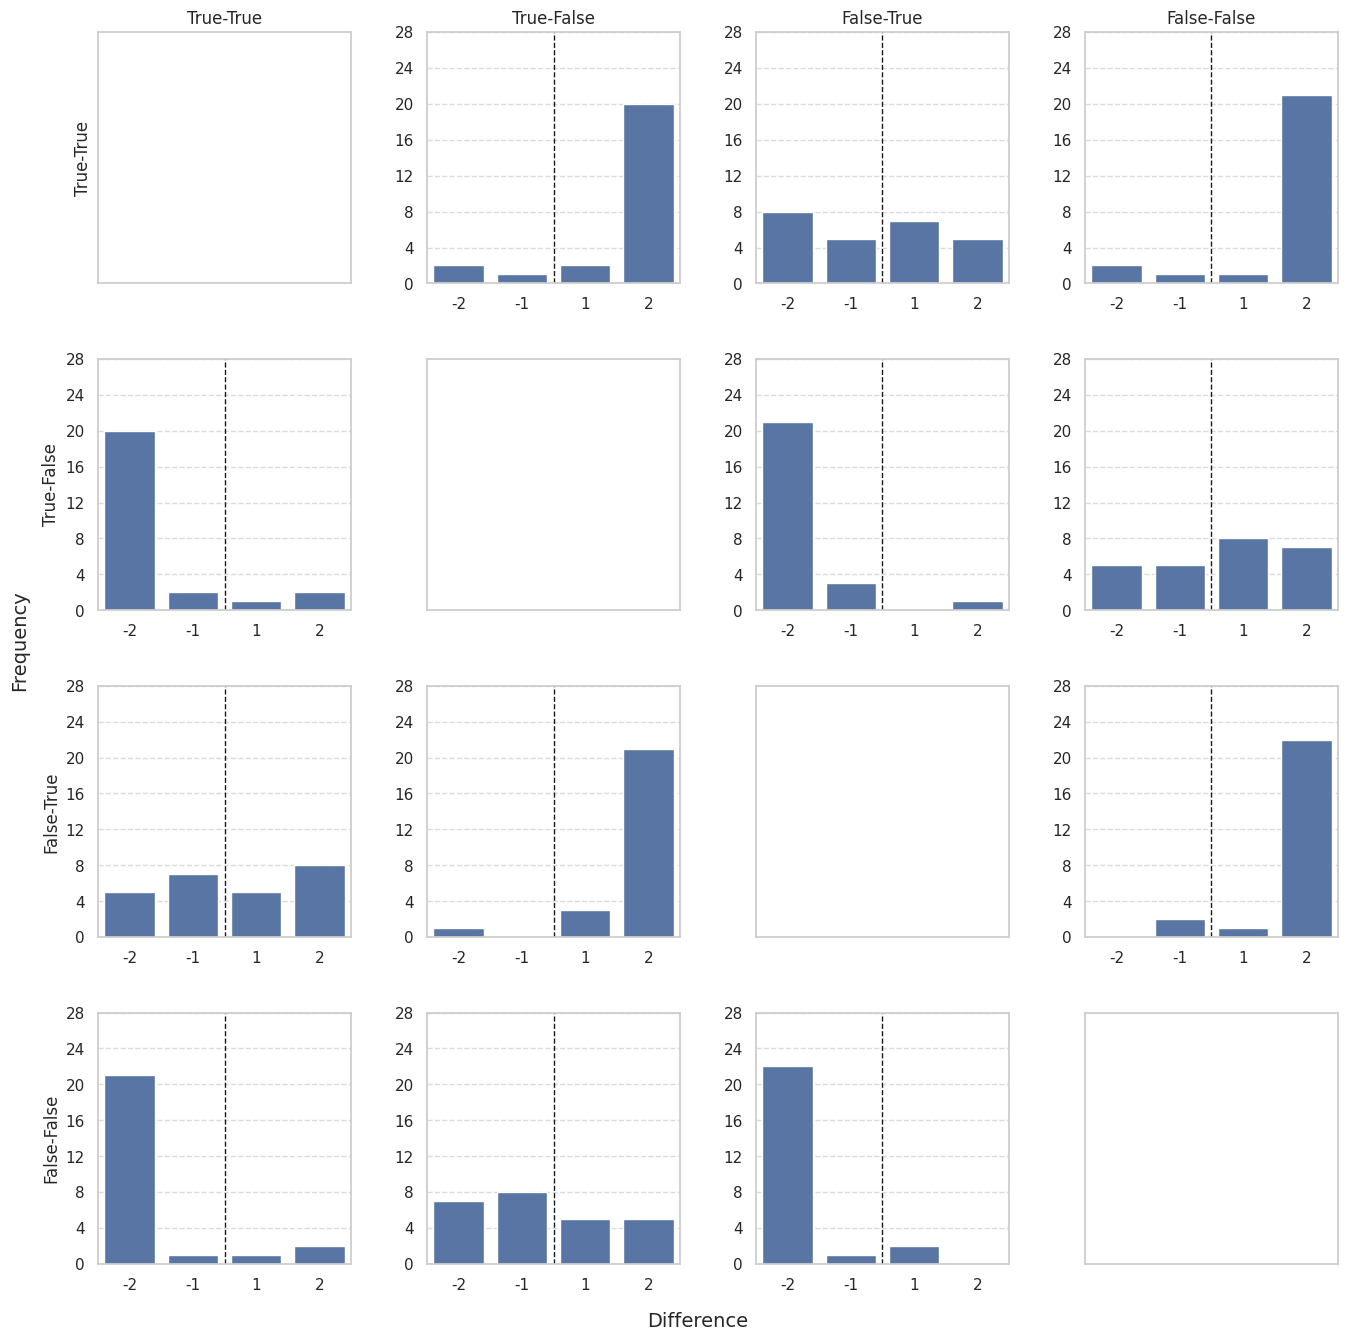

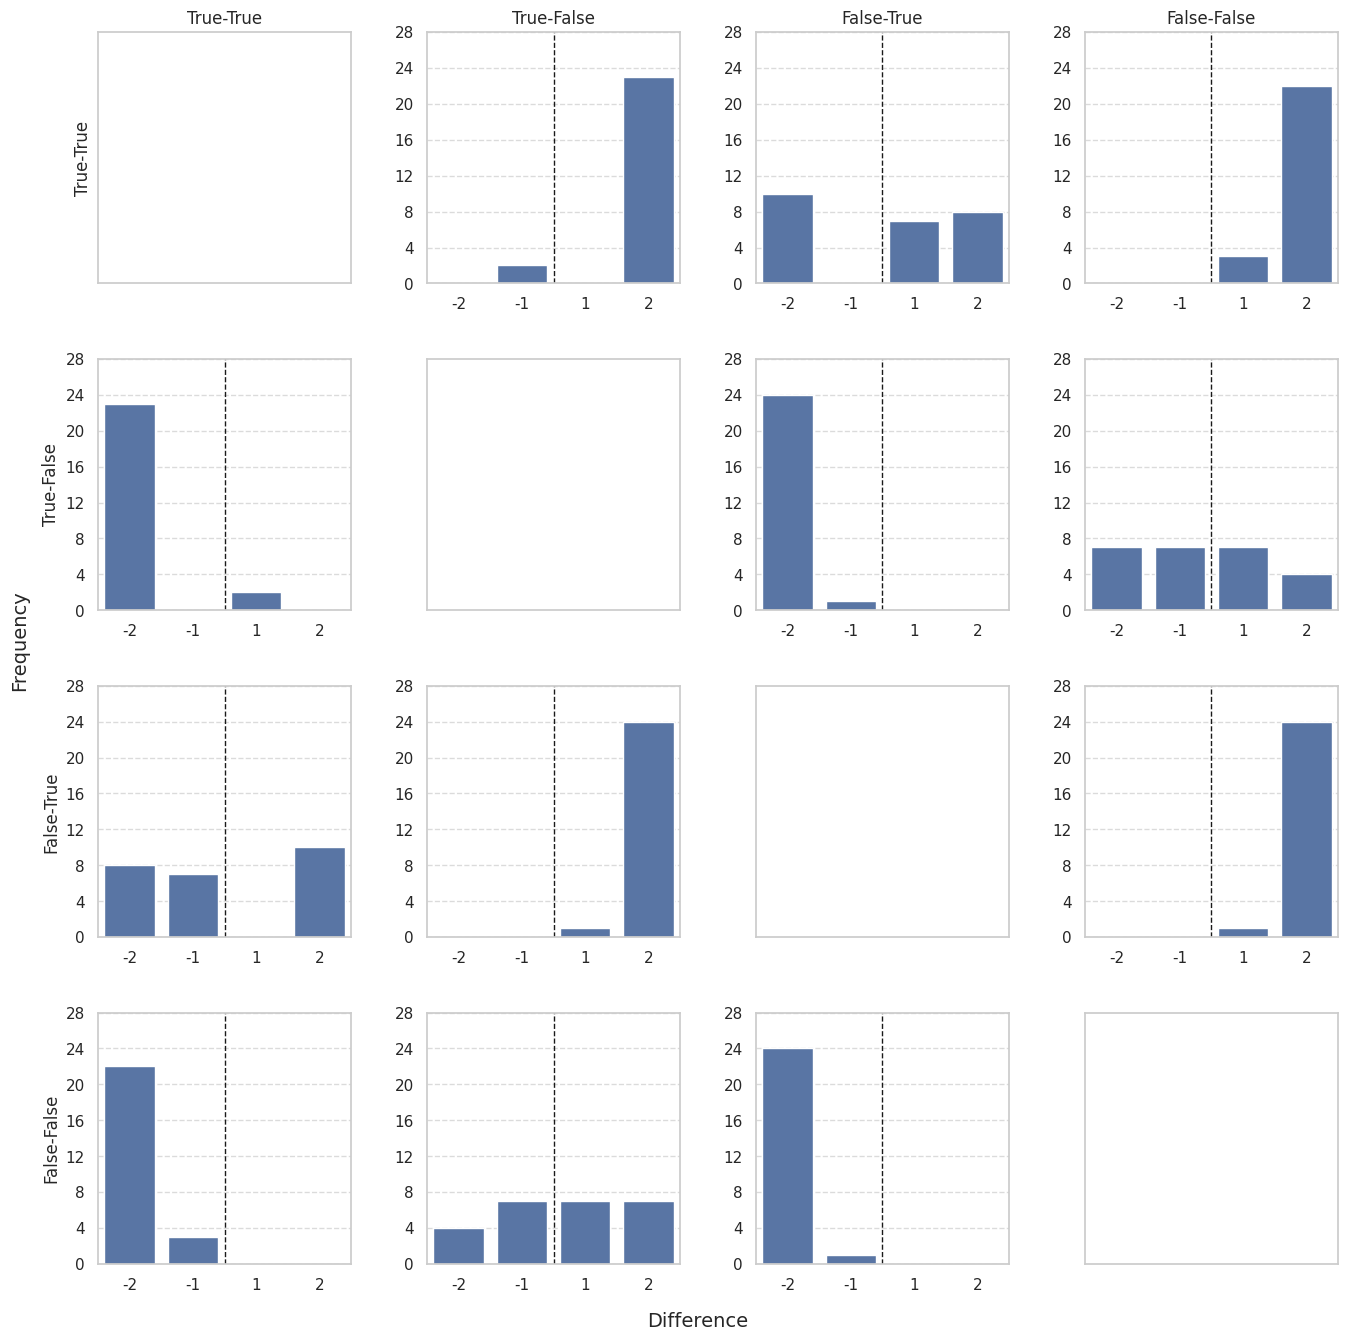

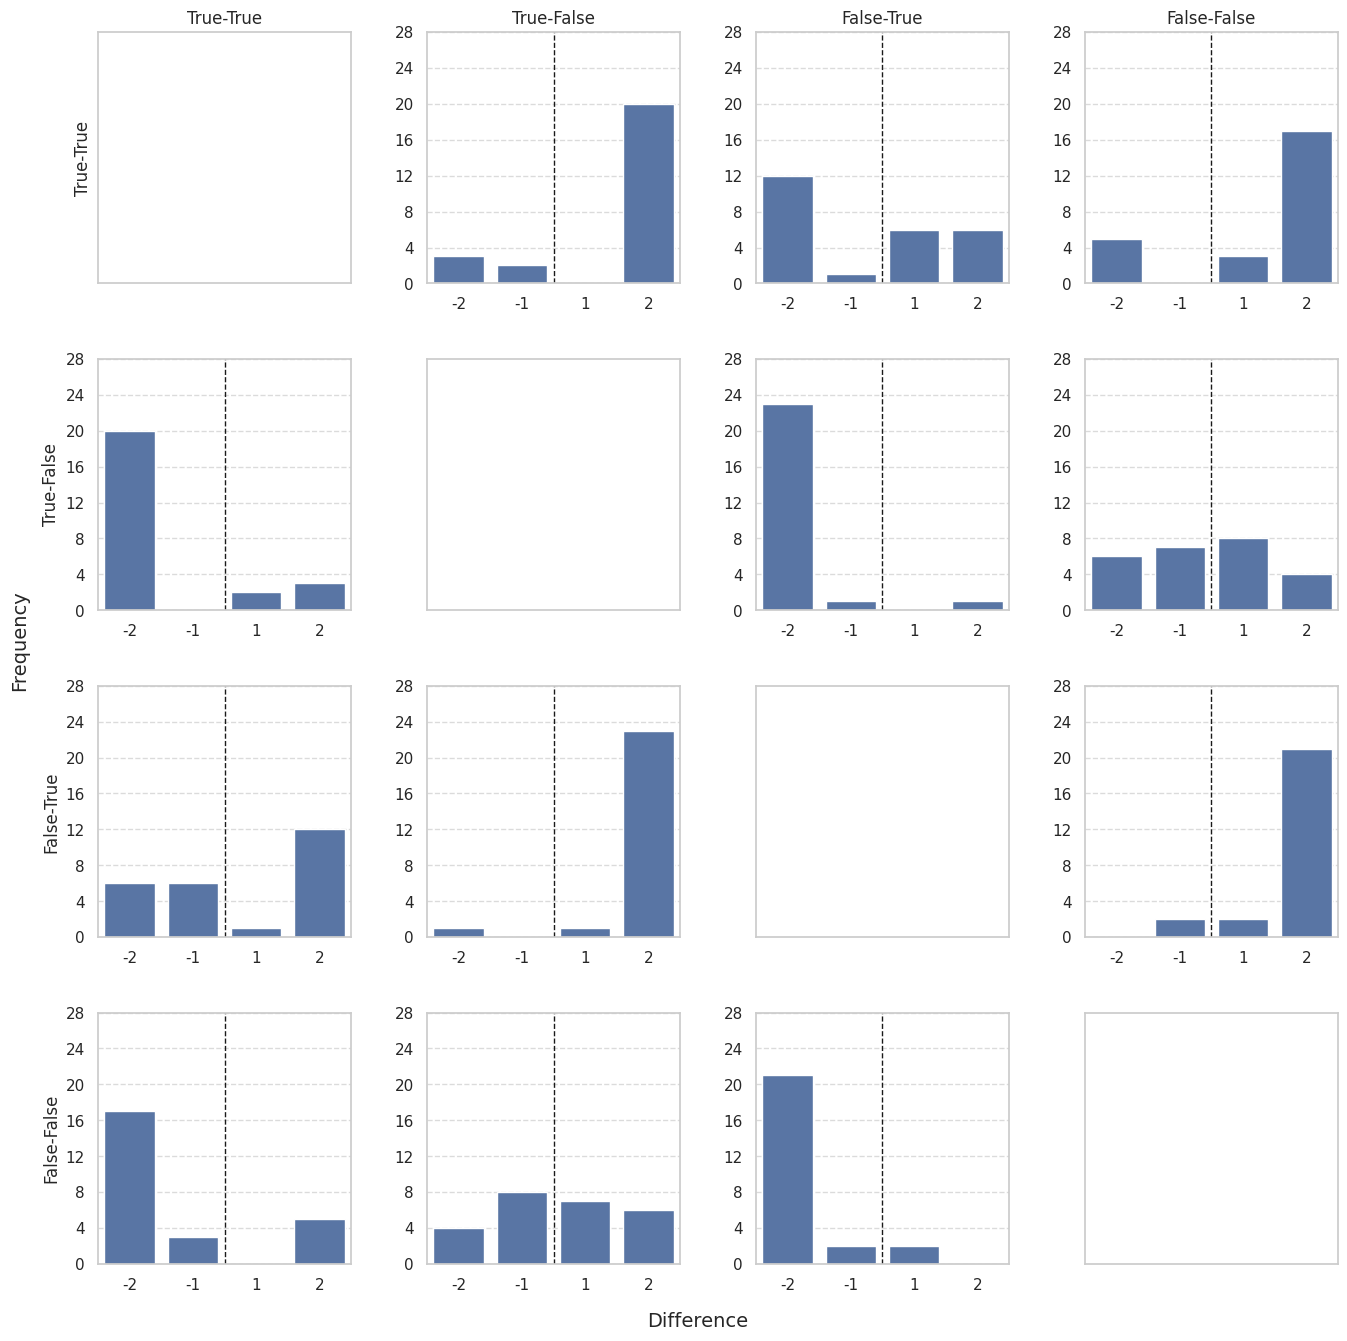

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def draw_arrow(ax, start_x, end_x, y, text):
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin

    dynamic_head_width = yrange * 0.03

    text_x_no_dialogue = (start_x + end_x) / 2

    ax.arrow(start_x, y, (end_x - start_x), 0,
             head_width=dynamic_head_width,
             head_length=0.2,
             fc='black', ec='black', lw=1.5,
             length_includes_head=True)

    ax.text(text_x_no_dialogue,
            y + 0.015 * yrange, text, ha='center', va='bottom')


sns.set_theme(style="whitegrid")

files = ['free10comb.csv', 'fixed5comb.csv', 'fixed10comb.csv']

for f in files:
    with open(f, 'r') as file:
        data = pd.read_csv(file)

    for i, c in enumerate(data['criteria'].unique()):
        fig, axs = plt.subplots(4, 4, figsize=(16, 16))
        # fig.suptitle(
        #     f"Comparison of different combinations of the same iterations for {f} and criteria {c}", fontsize=16, y=0.93)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        fig.text(0.5, fig.subplotpars.bottom - 0.03,
                 "Difference", ha='center', va='top', fontsize=14)
        fig.text(0.07, 0.5, "Frequency", va='center',
                 rotation='vertical', fontsize=14)

        combinations = [[True, True], [True, False],
                        [False, True], [False, False]]

        for j, comb in enumerate(combinations):
            for k, comb2 in enumerate(combinations):
                if j == k:
                    # Blank out the graph except the title and ylabel
                    ax = axs[j, k]
                    ax.set_xticks([])
                    ax.set_yticks([])

                    if j == 0 and k == 0:
                        ax.set_title(
                            f"{comb2[0]}-{comb2[1]}", fontsize=12)
                        ax.set_ylabel(
                            f"{comb[0]}-{comb[1]}", fontsize=12)
                    continue

                # Filter the data for the current criteria
                subset = data[data['criteria'] == c]

                # Filter the data for the current combination
                if j < k:
                    subset = subset[subset['first_student_level'] == comb[0]]
                    subset = subset[subset['first_materials'] == comb[1]]
                    subset = subset[subset['second_student_level'] == comb2[0]]
                    subset = subset[subset['second_materials'] == comb2[1]]
                else:
                    subset = subset[subset['first_student_level'] == comb2[0]]
                    subset = subset[subset['first_materials'] == comb2[1]]
                    subset = subset[subset['second_student_level'] == comb[0]]
                    subset = subset[subset['second_materials'] == comb[1]]
                    # Flip the counts
                    subset['difference'] = -subset['difference']

                difference = subset['difference'].value_counts()

                # Row and Column for each combination
                ax = axs[j, k]

                sns.barplot(
                    x=difference.index,
                    y=difference.values,
                    ax=ax,
                    order=[-2, -1, 1, 2],
                )

                ax.set_xlabel('')
                ax.set_ylabel('')

                # To only the first row add the title
                if j == 0:
                    ax.set_title(
                        f"{comb2[0]}-{comb2[1]}", fontsize=12)
                if k == 0:
                    ax.set_ylabel(
                        f"{comb[0]}-{comb[1]}", fontsize=12)

                # Ensure correct labels to values
                ax.set_xlim(-0.5, 3.5)
                ax.set_xticks([0, 1, 2, 3])
                ax.set_xticklabels(['-2', '-1', '1', '2'])

                ax.set_yticks(range(0, 29, 4))
                ax.set_ylim(0, 28)

                ax.axvline(x=1.5, color='k', linestyle='--', linewidth=1)
                ax.grid(axis='y', linestyle='--', alpha=0.7)

        plt.savefig(f'Images/{f.split(".")[0]}_{c}.png', dpi=300, bbox_inches='tight')                
    plt.show()